In [1]:
# manejo bbdd
import pandas as pd
import numpy as np
import re
import datetime
from scipy.stats import chi2_contingency

#gráficas
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Prophet
from prophet import Prophet

#estadística
import math
from scipy.stats import norm
from scipy import stats #para box-cox entre otros
from scipy.stats import skew

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#modelos y evaluación
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error,r2_score

In [2]:
datax = pd.read_csv("Airplane_Crashes_and_Fatalities_Since_1908_t0_2023 (1).csv", encoding='latin1')
datax

,Date,Time,Location,Operator,Flight #,Route,AC Type,Registration,cn/ln,Aboard,Aboard Passangers,Aboard Crew,Fatalities,Fatalities Passangers,Fatalities Crew,Ground,Summary
0,9/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,9/7/1909,NaN,"Juvisy-sur-Orge, France",NaN,NaN,Air show,Wright Byplane,SC1,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...
2,7/12/1912,6:30,"Atlantic City, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
3,8/6/1913,NaN,"Victoria, British Columbia, Canada",Private,NaN,NaN,Curtiss seaplane,NaN,NaN,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...
4,9/9/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,11/21/2022,10:15,"Medellín, Colombia",AeroPaca SAS,NaN,Medellín - Pizarro,Piper PA-31-350 Navajo Chieftain,HK-5121,31-7652004,8.0,6.0,2.0,8.0,6.0,2.0,0.0,The plane was chartered to carry a team of six...
4994,1/15/2023,10:50,"Pokhara, Nepal",Yeti Airlines,YT691,Kathmandu - Pokhara,ATR 72-500-72-212-A,9NANC,754,72.0,68.0,4.0,72.0,68.0,4.0,0.0,"Before approach, the pilot requested a change ..."
4995,9/16/2023,NaN,"Barcelos, Brazil",Manaus Aerotaxi,NaN,NaN,Embraer EMB-110P1 Bandeirante,PT-SOG,110490,14.0,12.0,2.0,14.0,12.0,2.0,0.0,The air taxi crashed in heavy rain while attem...
4996,10/29/2023,6:30,"Rio Branco, Brazil",ART Taxi Aero,NaN,Rio Branco - Envira,Cessna 208B Grand Caravan,PT-MEE,208B0344,12.0,10.0,2.0,12.0,10.0,2.0,0.0,The air taxi crashed into a heavy wooded area ...


In [3]:
#Aplicamos buenas costumbres y renombramos columnas.
cols = []
for i in range(len(datax.columns)):
    cols.append(datax.columns[i].lower())
datax.columns = cols
datax = datax.rename(columns={'flight #':'flight', 'ac type':'ac_type', 'cn/ln':'cn_ln', 'aboard passangers':'aboard_passangers', 'aboard crew':'aboard_crew', 'fatalities passangers':'fatalities_passangers', 'fatalities crew':'fatalities_crew'})
datax

,date,time,location,operator,flight,route,ac_type,registration,cn_ln,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,ground,summary
0,9/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,9/7/1909,NaN,"Juvisy-sur-Orge, France",NaN,NaN,Air show,Wright Byplane,SC1,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...
2,7/12/1912,6:30,"Atlantic City, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
3,8/6/1913,NaN,"Victoria, British Columbia, Canada",Private,NaN,NaN,Curtiss seaplane,NaN,NaN,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...
4,9/9/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,11/21/2022,10:15,"Medellín, Colombia",AeroPaca SAS,NaN,Medellín - Pizarro,Piper PA-31-350 Navajo Chieftain,HK-5121,31-7652004,8.0,6.0,2.0,8.0,6.0,2.0,0.0,The plane was chartered to carry a team of six...
4994,1/15/2023,10:50,"Pokhara, Nepal",Yeti Airlines,YT691,Kathmandu - Pokhara,ATR 72-500-72-212-A,9NANC,754,72.0,68.0,4.0,72.0,68.0,4.0,0.0,"Before approach, the pilot requested a change ..."
4995,9/16/2023,NaN,"Barcelos, Brazil",Manaus Aerotaxi,NaN,NaN,Embraer EMB-110P1 Bandeirante,PT-SOG,110490,14.0,12.0,2.0,14.0,12.0,2.0,0.0,The air taxi crashed in heavy rain while attem...
4996,10/29/2023,6:30,"Rio Branco, Brazil",ART Taxi Aero,NaN,Rio Branco - Envira,Cessna 208B Grand Caravan,PT-MEE,208B0344,12.0,10.0,2.0,12.0,10.0,2.0,0.0,The air taxi crashed into a heavy wooded area ...


In [4]:
datax.drop_duplicates()
datax

,date,time,location,operator,flight,route,ac_type,registration,cn_ln,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,ground,summary
0,9/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,9/7/1909,NaN,"Juvisy-sur-Orge, France",NaN,NaN,Air show,Wright Byplane,SC1,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...
2,7/12/1912,6:30,"Atlantic City, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
3,8/6/1913,NaN,"Victoria, British Columbia, Canada",Private,NaN,NaN,Curtiss seaplane,NaN,NaN,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...
4,9/9/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,11/21/2022,10:15,"Medellín, Colombia",AeroPaca SAS,NaN,Medellín - Pizarro,Piper PA-31-350 Navajo Chieftain,HK-5121,31-7652004,8.0,6.0,2.0,8.0,6.0,2.0,0.0,The plane was chartered to carry a team of six...
4994,1/15/2023,10:50,"Pokhara, Nepal",Yeti Airlines,YT691,Kathmandu - Pokhara,ATR 72-500-72-212-A,9NANC,754,72.0,68.0,4.0,72.0,68.0,4.0,0.0,"Before approach, the pilot requested a change ..."
4995,9/16/2023,NaN,"Barcelos, Brazil",Manaus Aerotaxi,NaN,NaN,Embraer EMB-110P1 Bandeirante,PT-SOG,110490,14.0,12.0,2.0,14.0,12.0,2.0,0.0,The air taxi crashed in heavy rain while attem...
4996,10/29/2023,6:30,"Rio Branco, Brazil",ART Taxi Aero,NaN,Rio Branco - Envira,Cessna 208B Grand Caravan,PT-MEE,208B0344,12.0,10.0,2.0,12.0,10.0,2.0,0.0,The air taxi crashed into a heavy wooded area ...


In [5]:
#Exploración inicial de los datos
#tipos de datos
#Nulos (comprobar, no trabajar con ellos todavía)
#columnas

In [6]:
datax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   4998 non-null   object 
 1   time                   3486 non-null   object 
 2   location               4994 non-null   object 
 3   operator               4988 non-null   object 
 4   flight                 1329 non-null   object 
 5   route                  4221 non-null   object 
 6   ac_type                4983 non-null   object 
 7   registration           4724 non-null   object 
 8   cn_ln                  4330 non-null   object 
 9   aboard                 4980 non-null   float64
 10  aboard_passangers      4769 non-null   float64
 11  aboard_crew            4772 non-null   float64
 12  fatalities             4990 non-null   float64
 13  fatalities_passangers  4756 non-null   float64
 14  fatalities_crew        4757 non-null   float64
 15  grou

In [7]:
datax.describe()

,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,ground
count,4980.000000,4769.000000,4772.000000,4990.000000,4756.000000,4757.000000,4956.000000
mean,31.195984,27.009017,4.479254,22.373547,19.053827,3.578516,1.719128
std,45.534788,44.111609,3.483859,35.061741,34.146127,3.167922,55.540273
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,3.000000,2.000000,4.000000,1.000000,2.000000,0.000000
50%,16.000000,12.000000,4.000000,11.000000,8.000000,3.000000,0.000000
75%,35.000000,30.000000,6.000000,25.000000,21.000000,5.000000,0.000000
max,644.000000,614.000000,61.000000,583.000000,560.000000,46.000000,2750.000000


In [8]:
datax.columns

Index(['date', 'time', 'location', 'operator', 'flight', 'route', 'ac_type',
       'registration', 'cn_ln', 'aboard', 'aboard_passangers', 'aboard_crew',
       'fatalities', 'fatalities_passangers', 'fatalities_crew', 'ground',
       'summary'],
      dtype='object')

In [9]:
#Analizar los distintos campos categóricos. 

#Definir tratamientos a realizar:
#Corrección de categorías: value_counts? gráficas?
#Hay algún campo que se pueda utilizar para feature extraction?
#Hay algún campo que deba eliminarse por cantidad de nulos? Se podría hacer algo para evitarlo?
#Hay algún campo que deba eliminarse ya que no aporta información?
#Una vez corregidas las categorías -> chequear test chi-cuadrado para eliminar variables relacionadas

In [10]:
def count_unique_values(dataframe, columns):
    for column in columns:
        print(f"Counts for column '{column}':")
        print(dataframe[column].value_counts())
        print("\n")

In [11]:
count_unique_values(datax, ['date', 'time', 'location', 'operator', 'flight', 'route', 'ac_type',
       'registration', 'cn_ln', 'summary'])

Counts for column 'date':
date
8/31/1988     4
9/11/2001     4
7/12/1951     3
1/25/1947     3
12/31/1970    3
             ..
12/30/1958    1
1/6/1959      1
1/8/1959      1
1/11/1959     1
11/1/2023     1
Name: count, Length: 4570, dtype: int64


Counts for column 'time':
time
15:00    38
17:00    33
14:00    32
12:00    32
11:00    32
         ..
17:11     1
11:08     1
12:59     1
20:39     1
15:11     1
Name: count, Length: 1060, dtype: int64


Counts for column 'location':
location
Moscow, Russia                                         17
Manila, Philippines                                    15
New York, New York                                     14
Sao Paulo, Brazil                                      13
Cairo, Egypt                                           13
                                                       ..
Near Kanash, Russia                                     1
NAS Argentia, Placentia Bay,  Newfoundland,  Canada     1
Anzio, Italy                               

In [12]:
# Realizamos un value_counts de todas las columans que aparecen como categoricas para dar una primera mirada.

# Separaremos la columna date en año, mes, dia para buscar patrones, eliminaremos la columna time por su gran cantidad de nulos, ya que no encontre una manera correcta de poder rellenar esos datos.

# En la columna location, buscaremos eliminar espacios y signos si los hay a traves de algun metodo regex o lambda, luego analizaremos agruparlos por ciudades y paises. (Ver que hacemos con esos 4 nulos)

# En la columna Operador, buscaremos eliminar espacios y signos a traves de algun metodo regex o lambda. (Ver que hacemos con esos 10 nulos).

# La columna flight la eliminaremos por su gran cantidad de nulos.

# La columna route nos puede aportar algun tipo de informacion podemos elegir algunas categorias y agruparlas depende de que cantidad de informacion nos aporte sino la eliminaremos.

# La columna ac_type nos ayudara a comprender ciertos aspectos de nuestro df ya que aqui tenemos los modelos de aviones involucrados en estos accidentes, hay que solo analizar que hacer con los 70 nulos que tenemos

# De las columnas registration y cn_ln que eliminaremos seguramente por ser poco relevantes para nuestro analisis.

# Por ultimo la columna summary seguramente sera eliminada ya que para el modelo que luego tenemos que hacer no nos servira, si ayudara al principio a limpiar nuestro df ya que tiene una gran cantidad de informacion que puede ayudar y/o rellenar las demas columnas del df, ademas de arrojar gran informacion para entender patrones o buscar curiosidades de los diferentes accidentes.

In [13]:
datax['date']=pd.to_datetime(datax['date']) #convertimos primero la columna Fecha en formato fecha-hora  
datax['year'] = datax['date'].dt.year
datax['month'] = datax['date'].dt.month
datax['day'] = datax['date'].dt.day
datax

,date,time,location,operator,flight,route,ac_type,registration,cn_ln,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,ground,summary,year,month,day
0,1908-09-17,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly...",1908,9,17
1,1909-09-07,NaN,"Juvisy-sur-Orge, France",NaN,NaN,Air show,Wright Byplane,SC1,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...,1909,9,7
2,1912-07-12,6:30,"Atlantic City, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...,1912,7,12
3,1913-08-06,NaN,"Victoria, British Columbia, Canada",Private,NaN,NaN,Curtiss seaplane,NaN,NaN,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...,1913,8,6
4,1913-09-09,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...,1913,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,2022-11-21,10:15,"Medellín, Colombia",AeroPaca SAS,NaN,Medellín - Pizarro,Piper PA-31-350 Navajo Chieftain,HK-5121,31-7652004,8.0,6.0,2.0,8.0,6.0,2.0,0.0,The plane was chartered to carry a team of six...,2022,11,21
4994,2023-01-15,10:50,"Pokhara, Nepal",Yeti Airlines,YT691,Kathmandu - Pokhara,ATR 72-500-72-212-A,9NANC,754,72.0,68.0,4.0,72.0,68.0,4.0,0.0,"Before approach, the pilot requested a change ...",2023,1,15
4995,2023-09-16,NaN,"Barcelos, Brazil",Manaus Aerotaxi,NaN,NaN,Embraer EMB-110P1 Bandeirante,PT-SOG,110490,14.0,12.0,2.0,14.0,12.0,2.0,0.0,The air taxi crashed in heavy rain while attem...,2023,9,16
4996,2023-10-29,6:30,"Rio Branco, Brazil",ART Taxi Aero,NaN,Rio Branco - Envira,Cessna 208B Grand Caravan,PT-MEE,208B0344,12.0,10.0,2.0,12.0,10.0,2.0,0.0,The air taxi crashed into a heavy wooded area ...,2023,10,29


In [14]:
# Eliminar las columnas especificadas de datax
datax.drop(['time', 'flight', 'registration', 'cn_ln'], axis=1, inplace=True)
datax

,date,location,operator,route,ac_type,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,ground,summary,year,month,day
0,1908-09-17,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly...",1908,9,17
1,1909-09-07,"Juvisy-sur-Orge, France",NaN,Air show,Wright Byplane,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...,1909,9,7
2,1912-07-12,"Atlantic City, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...,1912,7,12
3,1913-08-06,"Victoria, British Columbia, Canada",Private,NaN,Curtiss seaplane,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...,1913,8,6
4,1913-09-09,Over the North Sea,Military - German Navy,NaN,Zeppelin L-1 (airship),20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...,1913,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,2022-11-21,"Medellín, Colombia",AeroPaca SAS,Medellín - Pizarro,Piper PA-31-350 Navajo Chieftain,8.0,6.0,2.0,8.0,6.0,2.0,0.0,The plane was chartered to carry a team of six...,2022,11,21
4994,2023-01-15,"Pokhara, Nepal",Yeti Airlines,Kathmandu - Pokhara,ATR 72-500-72-212-A,72.0,68.0,4.0,72.0,68.0,4.0,0.0,"Before approach, the pilot requested a change ...",2023,1,15
4995,2023-09-16,"Barcelos, Brazil",Manaus Aerotaxi,NaN,Embraer EMB-110P1 Bandeirante,14.0,12.0,2.0,14.0,12.0,2.0,0.0,The air taxi crashed in heavy rain while attem...,2023,9,16
4996,2023-10-29,"Rio Branco, Brazil",ART Taxi Aero,Rio Branco - Envira,Cessna 208B Grand Caravan,12.0,10.0,2.0,12.0,10.0,2.0,0.0,The air taxi crashed into a heavy wooded area ...,2023,10,29


In [15]:
datax[datax['location'].isna()]

,date,location,operator,route,ac_type,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,ground,summary,year,month,day
360,1934-12-31,NaN,Aeroflot,NaN,Tupolev ANT-9,10.0,8.0,2.0,10.0,8.0,2.0,0.0,Crashed under unknown circumstances.,1934,12,31
643,1942-08-21,NaN,Deutsche Lufthansa,NaN,Siebel Si-204,4.0,2.0,2.0,4.0,2.0,2.0,0.0,"Lufthansa chairman, Von Gablenz killed.",1942,8,21
995,1947-11-27,NaN,China National Aviation Corporation,NaN,Douglas DC-3,3.0,0.0,3.0,2.0,0.0,2.0,0.0,The cargo plane was shot down by communist ant...,1947,11,27
2878,1977-01-20,NaN,North Canada Air,NaN,Bristol 170 Freighter 31M,2.0,0.0,2.0,1.0,0.0,1.0,0.0,The cargo plane stalled nearly vertical and cr...,1977,1,20


In [16]:
filas_a_imprimir = [360, 643, 995, 2878]
for fila in filas_a_imprimir:
    print(f"Fila {fila}: {datax['summary'].iloc[fila]}")

Fila 360: Crashed under unknown circumstances.
Fila 643: Lufthansa chairman, Von Gablenz killed.
Fila 995: The cargo plane was shot down by communist anti -aircraft fire.
Fila 2878: The cargo plane stalled nearly vertical and crashed. Shifting cargo.


In [17]:
# Al no lograr tener informacion suficiente para poder rellenar este campo ya que las diversas columnas no nos aportan demasiada informacion o nulla decidimos cambiar el valor nan por unknown.

In [18]:
# Reemplazar los valores nulos en la columna 'Location' con 'unknown'
datax['location'].fillna('unknown', inplace=True)
datax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   4998 non-null   datetime64[ns]
 1   location               4998 non-null   object        
 2   operator               4988 non-null   object        
 3   route                  4221 non-null   object        
 4   ac_type                4983 non-null   object        
 5   aboard                 4980 non-null   float64       
 6   aboard_passangers      4769 non-null   float64       
 7   aboard_crew            4772 non-null   float64       
 8   fatalities             4990 non-null   float64       
 9   fatalities_passangers  4756 non-null   float64       
 10  fatalities_crew        4757 non-null   float64       
 11  ground                 4956 non-null   float64       
 12  summary                4934 non-null   object        
 13  yea

In [19]:
# Dividir la columna 'location' en dos nuevas columnas 'city' y 'country'
split_location = datax['location'].str.split(',|-', n=1, expand=True)
# Asignar los valores de las nuevas columnas a 'city' y 'country'
datax['city'] = split_location[0]
datax['country'] = split_location[1]
# Si no hay coma o guion, mantener el mismo valor en ambas columnas
datax['country'].fillna(datax['city'], inplace=True)
datax

,date,location,operator,route,ac_type,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,ground,summary,year,month,day,city,country
0,1908-09-17,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly...",1908,9,17,Fort Myer,Virginia
1,1909-09-07,"Juvisy-sur-Orge, France",NaN,Air show,Wright Byplane,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...,1909,9,7,Juvisy,"sur-Orge, France"
2,1912-07-12,"Atlantic City, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...,1912,7,12,Atlantic City,New Jersey
3,1913-08-06,"Victoria, British Columbia, Canada",Private,NaN,Curtiss seaplane,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...,1913,8,6,Victoria,"British Columbia, Canada"
4,1913-09-09,Over the North Sea,Military - German Navy,NaN,Zeppelin L-1 (airship),20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...,1913,9,9,Over the North Sea,Over the North Sea
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,2022-11-21,"Medellín, Colombia",AeroPaca SAS,Medellín - Pizarro,Piper PA-31-350 Navajo Chieftain,8.0,6.0,2.0,8.0,6.0,2.0,0.0,The plane was chartered to carry a team of six...,2022,11,21,Medellín,Colombia
4994,2023-01-15,"Pokhara, Nepal",Yeti Airlines,Kathmandu - Pokhara,ATR 72-500-72-212-A,72.0,68.0,4.0,72.0,68.0,4.0,0.0,"Before approach, the pilot requested a change ...",2023,1,15,Pokhara,Nepal
4995,2023-09-16,"Barcelos, Brazil",Manaus Aerotaxi,NaN,Embraer EMB-110P1 Bandeirante,14.0,12.0,2.0,14.0,12.0,2.0,0.0,The air taxi crashed in heavy rain while attem...,2023,9,16,Barcelos,Brazil
4996,2023-10-29,"Rio Branco, Brazil",ART Taxi Aero,Rio Branco - Envira,Cessna 208B Grand Caravan,12.0,10.0,2.0,12.0,10.0,2.0,0.0,The air taxi crashed into a heavy wooded area ...,2023,10,29,Rio Branco,Brazil


In [20]:
datax.location.value_counts()

location
Moscow, Russia                                         17
Manila, Philippines                                    15
New York, New York                                     14
Cairo, Egypt                                           13
Sao Paulo, Brazil                                      13
                                                       ..
Near Kanash, Russia                                     1
NAS Argentia, Placentia Bay,  Newfoundland,  Canada     1
Anzio, Italy                                            1
Nipe Bay, Cuba                                          1
 Morelos,  Mexico                                       1
Name: count, Length: 4123, dtype: int64

In [21]:
datax.city.value_counts()

city
Moscow          19
Manila          15
New York        15
Cairo           13
Sao Paulo       13
                ..
Near Kanash      1
NAS Argentia     1
Anzio            1
Nipe Bay         1
 Morelos         1
Name: count, Length: 3924, dtype: int64

In [22]:
datax.country.value_counts()

country
 Russia                    240
 Brazil                    164
 Colombia                  146
 California                110
 France                    104
                          ... 
 Ryukyu Island, Okinawa      1
sur-Orge, France             1
 Jamacia                     1
Snilow,  Ukraine             1
  Mexico                     1
Name: count, Length: 855, dtype: int64

In [23]:
# Encontrar todos los valores que contienen las palabras clave en la columna 'location'
water_accidents = datax[datax['location'].str.contains(r'sea|ocean|channel|river', case=False)]
water_accidents

,date,location,operator,route,ac_type,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,ground,summary,year,month,day,city,country
4,1913-09-09,Over the North Sea,Military - German Navy,NaN,Zeppelin L-1 (airship),20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...,1913,9,9,Over the North Sea,Over the North Sea
15,1917-05-14,"Near Texel Island, North Sea",Military - German Navy,NaN,Zeppelin L-22 (airship),21.0,NaN,NaN,21.0,NaN,NaN,0.0,"Crashed into the sea from an altitude of 3,000...",1917,5,14,Near Texel Island,North Sea
16,1917-06-14,"Off Vlieland Island, North Sea",Military - German Navy,NaN,Zeppelin L-43 (airship),24.0,NaN,NaN,24.0,NaN,NaN,0.0,Shot down by British aircraft.,1917,6,14,Off Vlieland Island,North Sea
22,1918-08-11,"Ameland Island, North Sea",Military - German Navy,NaN,Zeppelin L-53 (airship),19.0,NaN,NaN,19.0,NaN,NaN,0.0,Shot down by british aircraft.,1918,8,11,Ameland Island,North Sea
30,1919-10-20,"English Channel off Forkstone, Kent",Aircraft Transport and Travel,NaN,De Havilland DH-4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Crashed into the sea while attempting to land ...,1919,10,20,English Channel off Forkstone,Kent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4710,2009-06-01,"Atlantic Ocean, 570 miles northeast of Natal, ...",Air France,Rio de Janeiro - Paris,Airbus A330-203,228.0,216.0,12.0,228.0,216.0,12.0,0.0,The Airbus went missing over the Atlantic Ocea...,2009,6,1,Atlantic Ocean,"570 miles northeast of Natal, Brazil"
4867,2014-03-08,South Indian Ocean,Malaysia Airlines,Kuala Lumpur- Beijing,Boeing 777-200,239.0,227.0,12.0,239.0,227.0,12.0,0.0,Radar contact was lost with the aircraft 2 hou...,2014,3,8,South Indian Ocean,South Indian Ocean
4868,2014-03-18,"Seattle, Washington",Helicopters Inc / KOMO TV,News reporting,Urocopter AS350 B2,2.0,1.0,1.0,2.0,1.0,1.0,0.0,The news helicopter crashed and burst into fla...,2014,3,18,Seattle,Washington
4885,2014-12-28,Java Sea,AirAsia,Surabaya - Singapore,Airbus A-320-216,162.0,155.0,7.0,162.0,155.0,7.0,0.0,The aircraft went missing while en route from ...,2014,12,28,Java Sea,Java Sea


In [24]:
datax.country.unique()

array([' Virginia', 'sur-Orge, France', ' New Jersey',
       ' British Columbia, Canada', 'Over the North Sea', ' Germany',
       ' Belgium', ' Bulgeria', ' England', 'Off Northern Germany',
       ' North Sea', 'Off western Denmark', ' France',
       'Over the Mediterranean', ' Ohio', ' Pennsylvania', ' Illinois',
       ' Italy', ' Maryland', ' Kent', ' Surrey, UK', ' Indiana', ' Iowa',
       ' Columbia', ' Spain', ' Wyoming', ' Minnisota', ' Wisconsin',
       'Off Gibraltar', ' Nevada', ' Australia', ' NY',
       'North Atlantic Ocean', ' China', ' Kent, England',
       ' Lorraine, France', ' Morocco', ' Picrdie, France',
       ' United Kingdom', ' Romania', ' Buckinghamshire, England',
       'Russia', 'Over the Mediterranean Sea', ' WY',
       'Over the English Channel', ' Colombia', 'United States',
       ' Georgia, USSR', ' Hungary', ' Mauritania', 'sur-Mer, France',
       'English Channel', ' Czechoslovakia', ' New York',
       ' Kent, Unied Kingdom', ' Oregon', ' Q

In [25]:
# Eliminar las palabras que están antes de la primera coma (incluyendo la coma y el espacio) en la columna 'country'
datax['country'] = datax['country'].apply(lambda x: re.sub(r'^[^,]+,\s*', '', str(x)))
datax

,date,location,operator,route,ac_type,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,ground,summary,year,month,day,city,country
0,1908-09-17,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly...",1908,9,17,Fort Myer,Virginia
1,1909-09-07,"Juvisy-sur-Orge, France",NaN,Air show,Wright Byplane,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...,1909,9,7,Juvisy,France
2,1912-07-12,"Atlantic City, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...,1912,7,12,Atlantic City,New Jersey
3,1913-08-06,"Victoria, British Columbia, Canada",Private,NaN,Curtiss seaplane,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...,1913,8,6,Victoria,Canada
4,1913-09-09,Over the North Sea,Military - German Navy,NaN,Zeppelin L-1 (airship),20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...,1913,9,9,Over the North Sea,Over the North Sea
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,2022-11-21,"Medellín, Colombia",AeroPaca SAS,Medellín - Pizarro,Piper PA-31-350 Navajo Chieftain,8.0,6.0,2.0,8.0,6.0,2.0,0.0,The plane was chartered to carry a team of six...,2022,11,21,Medellín,Colombia
4994,2023-01-15,"Pokhara, Nepal",Yeti Airlines,Kathmandu - Pokhara,ATR 72-500-72-212-A,72.0,68.0,4.0,72.0,68.0,4.0,0.0,"Before approach, the pilot requested a change ...",2023,1,15,Pokhara,Nepal
4995,2023-09-16,"Barcelos, Brazil",Manaus Aerotaxi,NaN,Embraer EMB-110P1 Bandeirante,14.0,12.0,2.0,14.0,12.0,2.0,0.0,The air taxi crashed in heavy rain while attem...,2023,9,16,Barcelos,Brazil
4996,2023-10-29,"Rio Branco, Brazil",ART Taxi Aero,Rio Branco - Envira,Cessna 208B Grand Caravan,12.0,10.0,2.0,12.0,10.0,2.0,0.0,The air taxi crashed into a heavy wooded area ...,2023,10,29,Rio Branco,Brazil


In [26]:
# Eliminar espacios en blanco al principio y al final de cada valor en la columna 'country'
datax['country'] = datax['country'].str.strip()

In [27]:
datax.country.unique()

array(['Virginia', 'France', 'New Jersey', 'Canada', 'Over the North Sea',
       'Germany', 'Belgium', 'Bulgeria', 'England',
       'Off Northern Germany', 'North Sea', 'Off western Denmark',
       'Over the Mediterranean', 'Ohio', 'Pennsylvania', 'Illinois',
       'Italy', 'Maryland', 'Kent', 'UK', 'Indiana', 'Iowa', 'Columbia',
       'Spain', 'Wyoming', 'Minnisota', 'Wisconsin', 'Off Gibraltar',
       'Nevada', 'Australia', 'NY', 'North Atlantic Ocean', 'China',
       'Morocco', 'United Kingdom', 'Romania', 'Russia',
       'Over the Mediterranean Sea', 'WY', 'Over the English Channel',
       'Colombia', 'United States', 'USSR', 'Hungary', 'Mauritania',
       'English Channel', 'Czechoslovakia', 'New York', 'Unied Kingdom',
       'Oregon', 'Idaho', 'Algeria', 'Connecticut', 'Atlantic Ocean',
       'Over the Gulf of Finland', 'Uruguay', 'AriÃ¨ge', 'Nebraska',
       'Brazil Florianopolis, Brazil', 'Minnesota', 'Kansas',
       'Netherlands', 'Texas', 'Brazil', 'Washington',

In [28]:
# Muchas ciudades de EE.UU quedaron como country, las voy a pasar a su respectivo pais
mapping = {
    'Virginia': 'EE. UU.',
    'Ohio': 'EE. UU.',
    'Pennsylvania': 'EE. UU.',
    'Illinois': 'EE. UU.',
    'Maryland': 'EE. UU.',
    'Indiana': 'EE. UU.',
    'Iowa': 'EE. UU.',
    'Columbia': 'EE. UU.',
    'Wyoming': 'EE. UU.',
    'Minnisota': 'EE. UU.',
    'Wisconsin': 'EE. UU.',
    'Nevada': 'EE. UU.',
    'NY': 'EE. UU.',
    'WY': 'EE. UU.',
    'New York': 'EE. UU.',
    'Connecticut': 'EE. UU.',
    'Oregon': 'EE. UU.',
    'Idaho': 'EE. UU.',
    'Nebraska': 'EE. UU.',
    'Minnesota': 'EE. UU.',
    'Kansas': 'EE. UU.',
    'Texas': 'EE. UU.',
    'Washington': 'EE. UU.',
    'Tennessee': 'EE. UU.',
    'West Virginia': 'EE. UU.',
    'California': 'EE. UU.',
    'New Mexico': 'EE. UU.',
    'Missouri': 'EE. UU.',
    'Massachusetts': 'EE. UU.',
    'Utah': 'EE. UU.',
    'Ilinois': 'EE. UU.',
    'Florida': 'EE. UU.',
    'Michigan': 'EE. UU.',
    'Arkansas': 'EE. UU.',
    'Colorado': 'EE. UU.',
    'Georgia': 'EE. UU.',
    'Montana': 'EE. UU.',
    'Mississippi': 'EE. UU.',
    'Alaska': 'EE. UU.',
    'Cailifornia': 'EE. UU.',
    'North Carolina': 'EE. UU.',
    'Kentucky': 'EE. UU.',
    'Maine': 'EE. UU.',
    'Washington D.C.': 'EE. UU.',
    'South Carolina': 'EE. UU.',
    'Alabama': 'EE. UU.',
    'Delaware': 'EE. UU.',
    'D.C.': 'EE. UU.',
    'Arizona': 'EE. UU.',
    'Mississipi': 'EE. UU.',
    'Near Houma Louisiana': 'EE. UU.',
    'South Dekota': 'EE. UU.',
    'New Hampshire': 'EE. UU.',
    'Hawaii': 'EE. UU.',
    'Over North Carolina': 'EE. UU.',
    'Washington DC': 'EE. UU.',
    'New Jersey': 'EE. UU.',
    'Jersey': 'EE. UU.',
    'United States': 'EE. UU.',
    'Washingon': 'EE. UU.',
    'South Dakota': 'EE. UU.',
    'Calilfornia': 'EE. UU.',
    'Virginia.': 'EE. UU.',
    ': Massachusetts': 'EE. UU.',
    'Off the Florida coast': 'EE. UU.',
    'Alaksa': 'EE. UU.'
}

# Reemplazar las palabras en la columna 'country' usando el diccionario de mapeo
datax['country'] = datax['country'].replace(mapping)

In [29]:
datax.country.value_counts()

country
EE. UU.                  1010
Russia                    257
Brazil                    176
Colombia                  152
France                    122
                         ... 
Aregntina                   1
Zimbabwe)                   1
Uzbekstan                   1
Newfoundland,  Canada       1
Micronesia                  1
Name: count, Length: 468, dtype: int64

In [30]:
canada_mapping = {
    'Ontario': 'Canadá',
    'Newfoundland': 'Canadá',
    'Labrador': 'Canadá',
    'Manitoba': 'Canadá',
    'Yukon Territory': 'Canadá',
    'Newfoundland,  Canada': 'Canadá',
    'Ontario': 'Canadá',
    'Canada': 'Canadá',
    '800 miles east of Newfoundland': 'Canadá',
    'Off the Oregon coast': 'Canadá',
    'PQ, Canada': 'Canadá',
    'Quebec, Canada': 'Canadá',
    'NWT,Canada': 'Canadá',
    'Quebec Canada': 'Canadá'
}

# Reemplazar las palabras en la columna 'country' usando el diccionario para Canadá
datax['country'] = datax['country'].replace(canada_mapping)
datax.country.value_counts()

country
EE. UU.                    1010
Russia                      257
Brazil                      176
Colombia                    152
Canadá                      144
                           ... 
Near Hong Kong                1
Val-de-Marne, France          1
Guadaloupe, West Indies       1
Sao Tomé & Principe           1
Micronesia                    1
Name: count, Length: 456, dtype: int64

In [31]:
uk_mapping = {
    'United Kingdom': 'UK',
    'English Channel': 'UK',
    'Unied Kingdom': 'UK',
    'Kent': 'UK',
    'English Channel': 'UK',
    'Northern Ireland': 'UK',
    'Argenina': 'Argentina',
    'Surrey, England': 'UK',
    'En route from Argentina  to  California': 'Argentina',
    'HI)': 'unknown',
    'Spain \t Moron AFB, Spain': 'Spain',
    '20 miles NW of Milan, Italy': 'Italy',
    '175 miles off the Egyptian coast': 'Egypt',
    'Brazil Florianopolis, Brazil': 'Brazil',
    'Val-de-Marne, France': 'France',
    'Tennesee': 'EE. UU.' ,
    'Deleware': 'EE. UU.', 
    'Louisiana': 'EE. UU.', 
    'Near Chicago Illinois': 'EE. UU.',
    'Massachutes': 'EE. UU.',
    'Spain Canary Islands': 'Spain', 
    'Canary Islands': 'Spain',
    'Northwest Territories Canada': 'Canadá', 
    'Off Chili': 'Chile',
    'Surrey,  England': 'UK', 
    'Alakska': 'EE. UU.', 
    'East Germany': 'Germany', 
    'Off the Alaska coast': 'EE. UU.'
}

# Reemplazar las palabras en la columna 'country' usando el diccionario para Canadá
datax['country'] = datax['country'].replace(uk_mapping)
datax.country.value_counts()

country
EE. UU.              1032
Russia                257
Brazil                177
Colombia              152
Canadá                145
                     ... 
Western Samoa           1
Eastern Libya           1
US Virgin Islands       1
Guadeloupe              1
Micronesia              1
Name: count, Length: 429, dtype: int64

In [32]:
datax.country.unique()

array(['EE. UU.', 'France', 'Canadá', 'Over the North Sea', 'Germany',
       'Belgium', 'Bulgeria', 'England', 'Off Northern Germany',
       'North Sea', 'Off western Denmark', 'Over the Mediterranean',
       'Italy', 'UK', 'Spain', 'Off Gibraltar', 'Australia',
       'North Atlantic Ocean', 'China', 'Morocco', 'Romania', 'Russia',
       'Over the Mediterranean Sea', 'Over the English Channel',
       'Colombia', 'USSR', 'Hungary', 'Mauritania', 'Czechoslovakia',
       'Algeria', 'Atlantic Ocean', 'Over the Gulf of Finland', 'Uruguay',
       'AriÃ¨ge', 'Brazil', 'Netherlands', 'Greece', 'Off Morocco',
       'Mexico', 'Pest Hungary', 'Algiers', 'Cuba', 'Iran',
       'East Sardinia', 'Madagascar', 'Argentina', 'Denmark',
       'New Zealand', 'Off Spain', 'Burma', 'Bulgaria', 'South Africa',
       'Thailand', 'Off Algiers', 'Iraq', 'Chile', 'Lebanon', 'Bolivia',
       'Aegean Sea', 'Yugoslavia', 'Peru', 'Syria', 'unknown', 'Pakistan',
       'Egypt', 'Honduras', 'Switzerland',

In [33]:
# Rellenar los valores nulos en la columna 'Operator' con 'Unknown'
datax['operator'] = datax['operator'].fillna('Unknown')
datax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   4998 non-null   datetime64[ns]
 1   location               4998 non-null   object        
 2   operator               4998 non-null   object        
 3   route                  4221 non-null   object        
 4   ac_type                4983 non-null   object        
 5   aboard                 4980 non-null   float64       
 6   aboard_passangers      4769 non-null   float64       
 7   aboard_crew            4772 non-null   float64       
 8   fatalities             4990 non-null   float64       
 9   fatalities_passangers  4756 non-null   float64       
 10  fatalities_crew        4757 non-null   float64       
 11  ground                 4956 non-null   float64       
 12  summary                4934 non-null   object        
 13  yea

In [34]:
# Eliminar la columna 'location'
datax.drop(columns=['location', 'route'], inplace=True)

# Ordenar el DataFrame según las columnas especificadas
order = ['date', 'year', 'month', 'day', 'city', 'country', 'operator', 'ac_type', 
         'aboard', 'aboard_passangers', 'aboard_crew', 'fatalities', 'fatalities_passangers', 
         'fatalities_crew', 'ground', 'summary']
datax = datax[order]

In [35]:
datax

,date,year,month,day,city,country,operator,ac_type,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,ground,summary
0,1908-09-17,1908,9,17,Fort Myer,EE. UU.,Military - U.S. Army,Wright Flyer III,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,1909-09-07,1909,9,7,Juvisy,France,Unknown,Wright Byplane,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...
2,1912-07-12,1912,7,12,Atlantic City,EE. UU.,Military - U.S. Navy,Dirigible,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
3,1913-08-06,1913,8,6,Victoria,Canadá,Private,Curtiss seaplane,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...
4,1913-09-09,1913,9,9,Over the North Sea,Over the North Sea,Military - German Navy,Zeppelin L-1 (airship),20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,2022-11-21,2022,11,21,Medellín,Colombia,AeroPaca SAS,Piper PA-31-350 Navajo Chieftain,8.0,6.0,2.0,8.0,6.0,2.0,0.0,The plane was chartered to carry a team of six...
4994,2023-01-15,2023,1,15,Pokhara,Nepal,Yeti Airlines,ATR 72-500-72-212-A,72.0,68.0,4.0,72.0,68.0,4.0,0.0,"Before approach, the pilot requested a change ..."
4995,2023-09-16,2023,9,16,Barcelos,Brazil,Manaus Aerotaxi,Embraer EMB-110P1 Bandeirante,14.0,12.0,2.0,14.0,12.0,2.0,0.0,The air taxi crashed in heavy rain while attem...
4996,2023-10-29,2023,10,29,Rio Branco,Brazil,ART Taxi Aero,Cessna 208B Grand Caravan,12.0,10.0,2.0,12.0,10.0,2.0,0.0,The air taxi crashed into a heavy wooded area ...


In [36]:
datax['ac_type'] = datax['ac_type'].fillna('Unknowns')
datax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   4998 non-null   datetime64[ns]
 1   year                   4998 non-null   int32         
 2   month                  4998 non-null   int32         
 3   day                    4998 non-null   int32         
 4   city                   4998 non-null   object        
 5   country                4998 non-null   object        
 6   operator               4998 non-null   object        
 7   ac_type                4998 non-null   object        
 8   aboard                 4980 non-null   float64       
 9   aboard_passangers      4769 non-null   float64       
 10  aboard_crew            4772 non-null   float64       
 11  fatalities             4990 non-null   float64       
 12  fatalities_passangers  4756 non-null   float64       
 13  fat

In [37]:
datax['summary'] = datax['summary'].fillna('Unknowns')
datax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   4998 non-null   datetime64[ns]
 1   year                   4998 non-null   int32         
 2   month                  4998 non-null   int32         
 3   day                    4998 non-null   int32         
 4   city                   4998 non-null   object        
 5   country                4998 non-null   object        
 6   operator               4998 non-null   object        
 7   ac_type                4998 non-null   object        
 8   aboard                 4980 non-null   float64       
 9   aboard_passangers      4769 non-null   float64       
 10  aboard_crew            4772 non-null   float64       
 11  fatalities             4990 non-null   float64       
 12  fatalities_passangers  4756 non-null   float64       
 13  fat

In [38]:
#Testeos de Chi-cuadrado
#Variables a testear:

#city                
#country                 
#operator               
#ac_type

In [39]:
data_crosstab = pd.crosstab(datax['operator'], datax['ac_type'], margins = False)
data_crosstab

ac_type,\tBoeing 737-8KN (WL),\tCurtiss C-46,\tEurocopter EC225LP Super Puma M2+,\tFairchild C-119C-15-FA Flying Boxcar,\tIlyushin IL-14M,\tLearjet 35A,\tMil Mi-172,\tLockheed C-130H Hercules,\t Avro 504,Antonov An-24 V,...,de Havilland DHC-6 Twin Otter 400,de Havilland DHC-6-200,de Havilland Dash-2 Beaver,de Havilland Dash-2 float plane,de Havilland Dove 1,de Havilland Dragon 1,de Hvilland 89A Dragon Rapide,de havilland 89 Dragon Rapide,de havilland Canada Twin Otter 200,deHavilland DH-86
operator,,,,,,,,,,,,,,,,,,,,,
\tAerolineas Flecha Austral - ALFA,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
\tAmazonavesAir Taxi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
\tCHC Helikopter Service,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
\tLoide Aéreo Nacional,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
\tMilitary - Tajik National Guard,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zantop Air Transport,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zantop International Airlines,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
de Havilland Air Service,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
chi2_contingency(data_crosstab, correction=False)

Chi2ContingencyResult(statistic=6183033.197744112, pvalue=0.0, dof=5576232, expected_freq=array([[0.00020008, 0.00020008, 0.00020008, ..., 0.00020008, 0.00020008,
        0.00020008],
       [0.00020008, 0.00020008, 0.00020008, ..., 0.00020008, 0.00020008,
        0.00020008],
       [0.00020008, 0.00020008, 0.00020008, ..., 0.00020008, 0.00020008,
        0.00020008],
       ...,
       [0.00020008, 0.00020008, 0.00020008, ..., 0.00020008, 0.00020008,
        0.00020008],
       [0.00020008, 0.00020008, 0.00020008, ..., 0.00020008, 0.00020008,
        0.00020008],
       [0.00020008, 0.00020008, 0.00020008, ..., 0.00020008, 0.00020008,
        0.00020008]]))

In [41]:
data_crosstab = pd.crosstab(datax['operator'], datax['country'], margins = False)
data_crosstab

country,", Hungary",",Coatia",110 miles West of Ireland,325 miles east of Wake Island,AK,Aegean Sea,Afghanistan,Afghanstan,Africa,Airzona,...,Zimbabwe,Zimbabwe),bulgaria,in-Teesdale. United Kingdom,"near Strasbourg, France",off Angola,off Australia,off Bermuda,off the Philippine island of Elalat,unknown
operator,,,,,,,,,,,,,,,,,,,,,
\tAerolineas Flecha Austral - ALFA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
\tAmazonavesAir Taxi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
\tCHC Helikopter Service,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
\tLoide Aéreo Nacional,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
\tMilitary - Tajik National Guard,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zantop Air Transport,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zantop International Airlines,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
de Havilland Air Service,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
chi2_contingency(data_crosstab, correction=False)

Chi2ContingencyResult(statistic=1164601.8269151235, pvalue=0.0, dof=968992, expected_freq=array([[0.00020008, 0.00020008, 0.00020008, ..., 0.00020008, 0.00020008,
        0.0010004 ],
       [0.00020008, 0.00020008, 0.00020008, ..., 0.00020008, 0.00020008,
        0.0010004 ],
       [0.00020008, 0.00020008, 0.00020008, ..., 0.00020008, 0.00020008,
        0.0010004 ],
       ...,
       [0.00020008, 0.00020008, 0.00020008, ..., 0.00020008, 0.00020008,
        0.0010004 ],
       [0.00020008, 0.00020008, 0.00020008, ..., 0.00020008, 0.00020008,
        0.0010004 ],
       [0.00020008, 0.00020008, 0.00020008, ..., 0.00020008, 0.00020008,
        0.0010004 ]]))

In [43]:
data_crosstab = pd.crosstab(datax['ac_type'], datax['country'], margins = False)
data_crosstab

country,", Hungary",",Coatia",110 miles West of Ireland,325 miles east of Wake Island,AK,Aegean Sea,Afghanistan,Afghanstan,Africa,Airzona,...,Zimbabwe,Zimbabwe),bulgaria,in-Teesdale. United Kingdom,"near Strasbourg, France",off Angola,off Australia,off Bermuda,off the Philippine island of Elalat,unknown
ac_type,,,,,,,,,,,,,,,,,,,,,
\tBoeing 737-8KN (WL),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
\tCurtiss C-46,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
\tEurocopter EC225LP Super Puma M2+,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
\tFairchild C-119C-15-FA Flying Boxcar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
\tIlyushin IL-14M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
de Havilland Dragon 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
de Hvilland 89A Dragon Rapide,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
de havilland 89 Dragon Rapide,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
chi2_contingency(data_crosstab, correction=False)

Chi2ContingencyResult(statistic=1117463.7976041602, pvalue=0.0, dof=1054164, expected_freq=array([[0.00020008, 0.00020008, 0.00020008, ..., 0.00020008, 0.00020008,
        0.0010004 ],
       [0.00020008, 0.00020008, 0.00020008, ..., 0.00020008, 0.00020008,
        0.0010004 ],
       [0.00020008, 0.00020008, 0.00020008, ..., 0.00020008, 0.00020008,
        0.0010004 ],
       ...,
       [0.00020008, 0.00020008, 0.00020008, ..., 0.00020008, 0.00020008,
        0.0010004 ],
       [0.00020008, 0.00020008, 0.00020008, ..., 0.00020008, 0.00020008,
        0.0010004 ],
       [0.00020008, 0.00020008, 0.00020008, ..., 0.00020008, 0.00020008,
        0.0010004 ]]))

In [45]:
#preguntar lo del pvalue, ya que siendo menor de 0.05 la hipotesis es nula por lo tanto se rechaza y se pueden eliminar columnas si es necesario ya que se correlacionan entre ellas??

In [46]:
#Numerical Data - Exploration

#Para las distintas variables numéricas

#Explorar nulls
#Explorar outliers
#Hay alguna variable a la que haya que aplicarle transformaciones (log, raiz cuadrada)?
#Explorar correlaciones entre variables numéricas

In [47]:
datax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   4998 non-null   datetime64[ns]
 1   year                   4998 non-null   int32         
 2   month                  4998 non-null   int32         
 3   day                    4998 non-null   int32         
 4   city                   4998 non-null   object        
 5   country                4998 non-null   object        
 6   operator               4998 non-null   object        
 7   ac_type                4998 non-null   object        
 8   aboard                 4980 non-null   float64       
 9   aboard_passangers      4769 non-null   float64       
 10  aboard_crew            4772 non-null   float64       
 11  fatalities             4990 non-null   float64       
 12  fatalities_passangers  4756 non-null   float64       
 13  fat

In [48]:
def count_unique_values(dataframe, columns):
    for column in columns:
        print(f"Counts for column '{column}':")
        print(dataframe[column].value_counts())
        print("\n")

In [49]:
count_unique_values(datax, ['year', 'month', 'day', 'aboard', 'aboard_passangers', 'aboard_crew', 'fatalities', 
                    'fatalities_passangers', 'fatalities_crew', 'ground'])

Counts for column 'year':
year
1946    88
1989    83
1947    82
1948    77
1972    77
        ..
1913     3
1915     2
1909     1
1912     1
1908     1
Name: count, Length: 113, dtype: int64


Counts for column 'month':
month
12    495
1     459
9     451
8     450
11    442
10    426
7     424
3     424
6     362
2     360
5     359
4     346
Name: count, dtype: int64


Counts for column 'day':
day
8     185
15    179
24    176
10    175
14    173
21    173
27    172
3     172
9     170
2     170
11    169
22    167
17    165
6     165
12    163
4     162
18    159
26    158
29    158
16    157
19    156
23    155
20    155
28    154
13    152
25    152
30    150
1     147
5     147
7     146
31    116
Name: count, dtype: int64


Counts for column 'aboard':
aboard
3.0      278
2.0      244
4.0      202
5.0      190
10.0     175
        ... 
356.0      1
258.0      1
259.0      1
290.0      1
190.0      1
Name: count, Length: 244, dtype: int64


Counts for column 'aboard_passangers':
a

In [50]:
# Empezamos eliminando la columna ground y summary.
# Luego creamos una nueva columna llamada fatality ratio para calcular el porcentaje de muertes de los diferentes accidentes y asi poder estudiar una nueva variable.

In [51]:
datax.drop(['ground', 'summary'], axis=1, inplace=True)
datax['fatality_ratio (%)'] = (datax['fatalities'] / datax['aboard'])*100
datax

,date,year,month,day,city,country,operator,ac_type,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,fatality_ratio (%)
0,1908-09-17,1908,9,17,Fort Myer,EE. UU.,Military - U.S. Army,Wright Flyer III,2.0,1.0,1.0,1.0,1.0,0.0,50.0
1,1909-09-07,1909,9,7,Juvisy,France,Unknown,Wright Byplane,1.0,0.0,1.0,1.0,0.0,0.0,100.0
2,1912-07-12,1912,7,12,Atlantic City,EE. UU.,Military - U.S. Navy,Dirigible,5.0,0.0,5.0,5.0,0.0,5.0,100.0
3,1913-08-06,1913,8,6,Victoria,Canadá,Private,Curtiss seaplane,1.0,0.0,1.0,1.0,0.0,1.0,100.0
4,1913-09-09,1913,9,9,Over the North Sea,Over the North Sea,Military - German Navy,Zeppelin L-1 (airship),20.0,NaN,NaN,14.0,NaN,NaN,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,2022-11-21,2022,11,21,Medellín,Colombia,AeroPaca SAS,Piper PA-31-350 Navajo Chieftain,8.0,6.0,2.0,8.0,6.0,2.0,100.0
4994,2023-01-15,2023,1,15,Pokhara,Nepal,Yeti Airlines,ATR 72-500-72-212-A,72.0,68.0,4.0,72.0,68.0,4.0,100.0
4995,2023-09-16,2023,9,16,Barcelos,Brazil,Manaus Aerotaxi,Embraer EMB-110P1 Bandeirante,14.0,12.0,2.0,14.0,12.0,2.0,100.0
4996,2023-10-29,2023,10,29,Rio Branco,Brazil,ART Taxi Aero,Cessna 208B Grand Caravan,12.0,10.0,2.0,12.0,10.0,2.0,100.0


C:\Users\matte\AppData\Local\Temp\ipykernel_26652\1345066053.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(datax[column])
C:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


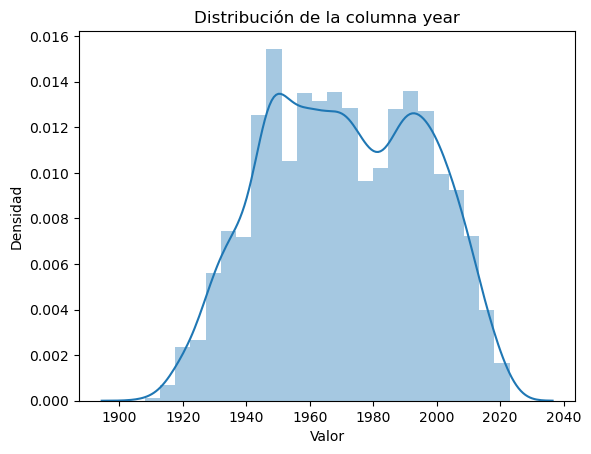

C:\Users\matte\AppData\Local\Temp\ipykernel_26652\1345066053.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(datax[column])
C:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


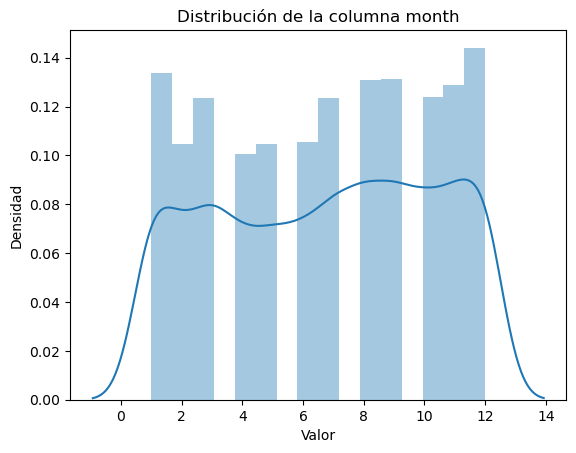

C:\Users\matte\AppData\Local\Temp\ipykernel_26652\1345066053.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(datax[column])
C:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


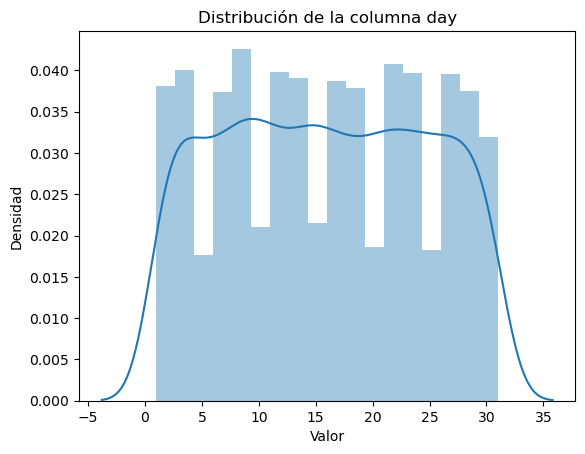

C:\Users\matte\AppData\Local\Temp\ipykernel_26652\1345066053.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(datax[column])
C:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


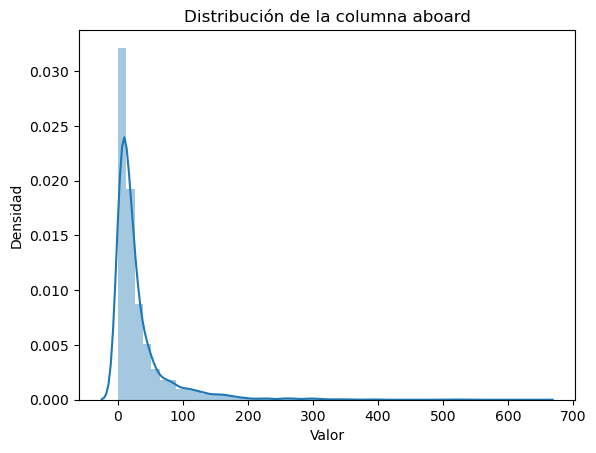

C:\Users\matte\AppData\Local\Temp\ipykernel_26652\1345066053.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(datax[column])
C:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


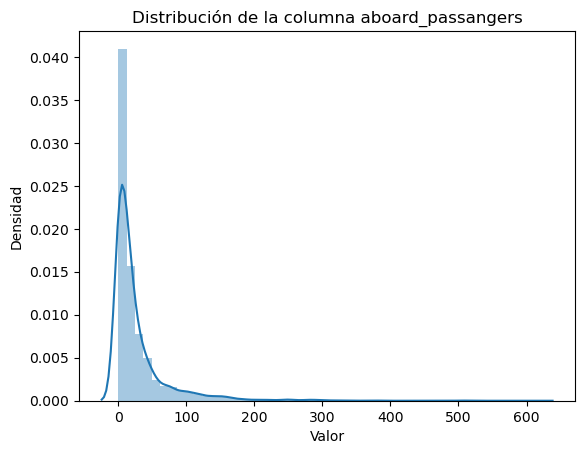

C:\Users\matte\AppData\Local\Temp\ipykernel_26652\1345066053.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(datax[column])
C:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


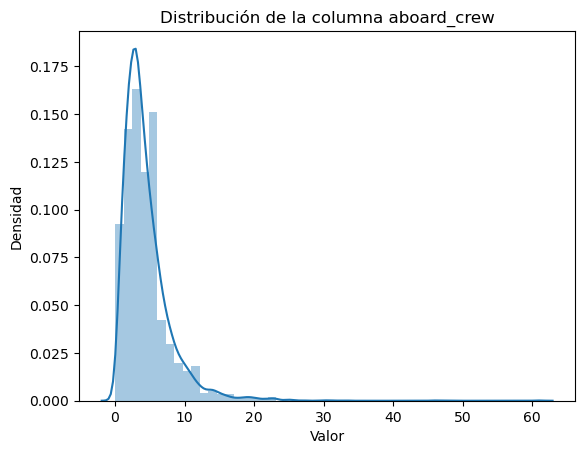

C:\Users\matte\AppData\Local\Temp\ipykernel_26652\1345066053.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(datax[column])
C:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


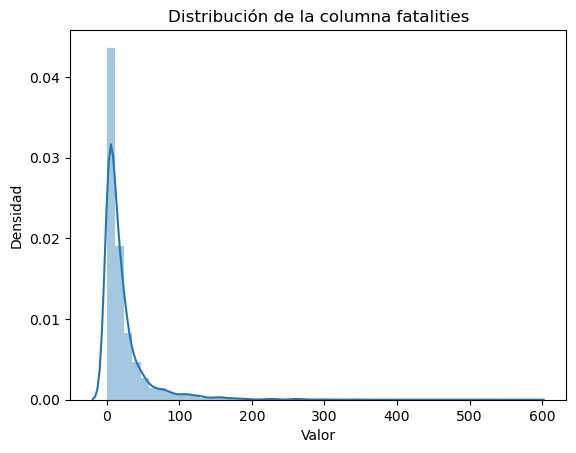

C:\Users\matte\AppData\Local\Temp\ipykernel_26652\1345066053.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(datax[column])
C:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


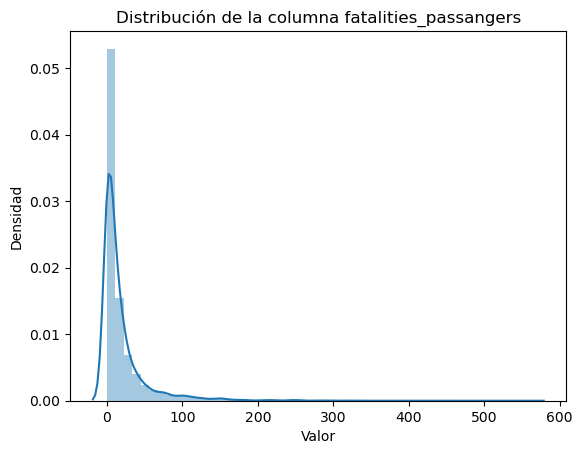

C:\Users\matte\AppData\Local\Temp\ipykernel_26652\1345066053.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(datax[column])
C:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


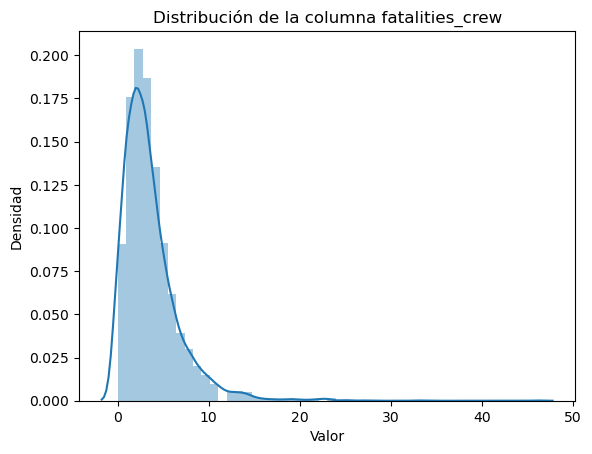

C:\Users\matte\AppData\Local\Temp\ipykernel_26652\1345066053.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(datax[column])
C:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


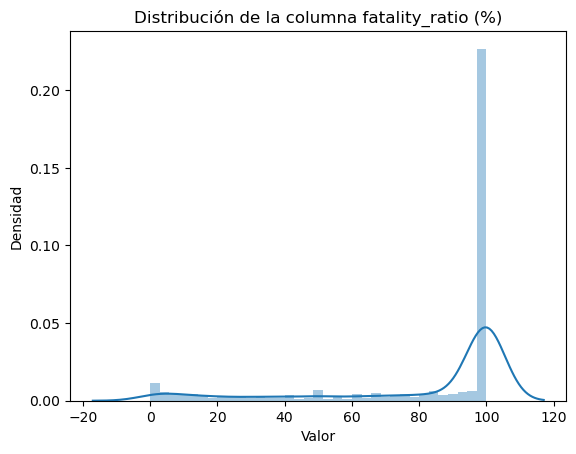

In [52]:
#chequeamos nuestros datos:
numeric_columns = datax.select_dtypes(include=['int32', 'float64']).columns
# Iterar sobre las columnas numéricas y generar un gráfico de distribución
for column in numeric_columns:
    sns.distplot(datax[column])
    plt.title(f'Distribución de la columna {column}')
    plt.xlabel('Valor')
    plt.ylabel('Densidad')
    plt.show()

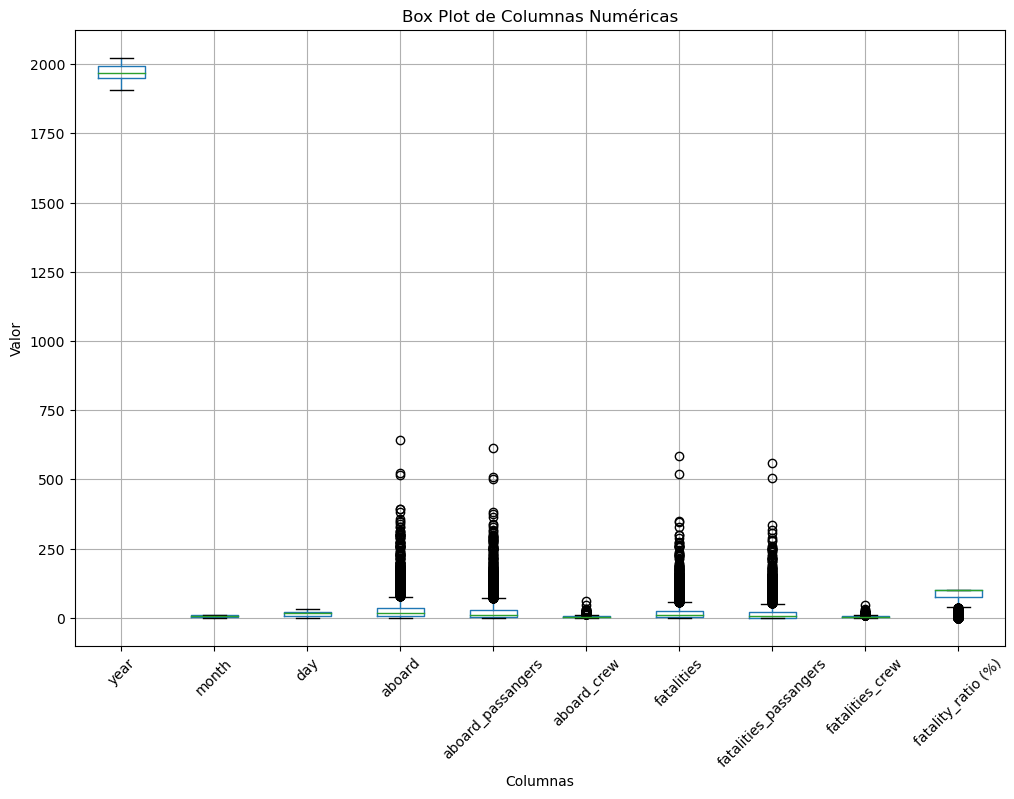

In [53]:
# Seleccionar solo las columnas numéricas
datax_numeric = datax.select_dtypes(include='number')

# Crear el box plot para cada columna numérica
plt.figure(figsize=(12, 8))
datax_numeric.boxplot()
plt.title('Box Plot de Columnas Numéricas')
plt.xlabel('Columnas')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [54]:
def count_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = (column < lower_bound) | (column > upper_bound)
    return outliers.sum()

# Contar outliers para cada columna numérica
outliers_count = datax_numeric.apply(count_outliers)
print(outliers_count)

year                       0
month                      0
day                        0
aboard                   500
aboard_passangers        497
aboard_crew              145
fatalities               455
fatalities_passangers    446
fatalities_crew          226
fatality_ratio (%)       699
dtype: int64


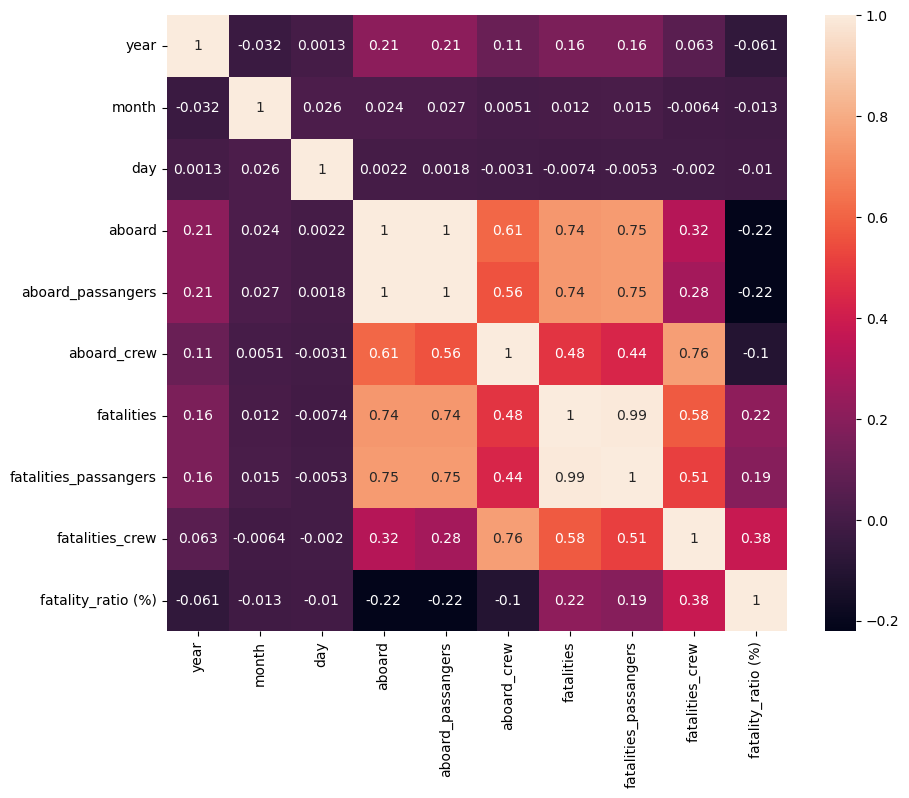

In [55]:
data_corr = datax.select_dtypes(np.number)
corr_matrix=data_corr.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [56]:
#Luego de una mirada general podemos decir que las columnas year, month y day quedaron bastante bien, con ellas desarollaremos diferentes cuestiones y en cuanto a las columnas que abarcan aboard y fatalities casi todas son una l, estaria bien aplicar una logaritimica?

#En la columna aboard tenemos pocos nulos que podemos rellenar con algun metodo

#En la columna aboard_passangers nos pasa algo muy parecido a la columna aboard.

#En la columna aboard_crew lo mismo de arriba
 
#Con respecto a estas columnas mas de lo mismo ver como podemos tratar esos nulos y outliers ya que toda informacion es importante, podria ser una buena idea realizar una matriz de correlacion para ver como ya puede a ver algun tipo de conexion entre estas variables?

#"fatalities_passangers", "fatalities", "fatalities_crew".

#Con este .corr podemos ver una primera imagen de como estan nuestras variables numericas podemos observar una alta correlacion entre las columnas fatalities y fatalities passengers asique eliminaremos una, y tambien altas correlaciones entre aboard crew y passengers y fatalities crew y passengers, aqui tambien seguramente eliminemos columnas.

In [57]:
# Filtrar las filas donde hay valores nulos en la columna 'Aboard'
null_aboard_rows = datax[datax['aboard'].isnull()]
null_aboard_rows

,date,year,month,day,city,country,operator,ac_type,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,fatality_ratio (%)
26,1919-07-21,1919,7,21,Chicago,EE. UU.,Wingfoot Air Express Goodyear Tire,FD Type Dirigible,NaN,NaN,NaN,3.0,2.0,1.0,NaN
103,1925-09-07,1925,9,7,Toul,France,CIDNA,Spad 33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
347,1934-08-10,1934,8,10,Ningbo,China,China National Aviation Corporation,Sikorsky S-38B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
383,1935-08-13,1935,8,13,Hangow,China,China National Aviation Corporation,Sikorsky S-38B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450,1936-12-26,1936,12,26,Nanking,China,China National Aviation Corporation,Douglas DC-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
649,1942-10-01,1942,10,1,Kunming,China,China National Aviation Corporation,Douglas C-47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
751,1944-11-09,1944,11,9,Seljord,Norway,Military - U.S. Army Air Corps,Unknowns,NaN,NaN,NaN,NaN,NaN,NaN,NaN
850,1946-03-18,1946,3,18,Between Chungking and Shanghai,China,China National Aviation Corporation,Unknowns,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1186,1950-07-30,1950,7,30,Algrete,Brazil,"SAVG (S.A. Viacao Gaucha, ) SAVG",Unknowns,NaN,NaN,NaN,10.0,NaN,NaN,NaN
1224,1951-01-20,1951,1,20,Huilyo,Peru,Military - TAM,Douglas DC-3,NaN,NaN,NaN,16.0,NaN,NaN,NaN


In [58]:
# Filtrar las filas donde hay valores nulos en la columna 'fatalities'
null_aboard_rows1 = datax[datax['fatalities'].isnull()]
null_aboard_rows1

,date,year,month,day,city,country,operator,ac_type,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,fatality_ratio (%)
103,1925-09-07,1925,9,7,Toul,France,CIDNA,Spad 33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
347,1934-08-10,1934,8,10,Ningbo,China,China National Aviation Corporation,Sikorsky S-38B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
383,1935-08-13,1935,8,13,Hangow,China,China National Aviation Corporation,Sikorsky S-38B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450,1936-12-26,1936,12,26,Nanking,China,China National Aviation Corporation,Douglas DC-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
649,1942-10-01,1942,10,1,Kunming,China,China National Aviation Corporation,Douglas C-47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
751,1944-11-09,1944,11,9,Seljord,Norway,Military - U.S. Army Air Corps,Unknowns,NaN,NaN,NaN,NaN,NaN,NaN,NaN
850,1946-03-18,1946,3,18,Between Chungking and Shanghai,China,China National Aviation Corporation,Unknowns,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1443,1954-03-13,1954,3,13,Dien Bien Phu,South Vietnam,Aigle Azur,C-46,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# Calcular la media de cada columna
mean_fatalities = datax['fatalities'].mean()
mean_fatalities_passengers = datax['fatalities_passangers'].mean()
mean_fatalities_crew = datax['fatalities_crew'].mean()

print("Mean Fatalities:", mean_fatalities)
print("Mean Fatalities Passengers:", mean_fatalities_passengers)
print("Mean Fatalities Crew:", mean_fatalities_crew)

Mean Fatalities: 22.37354709418838
Mean Fatalities Passengers: 19.053826745164002
Mean Fatalities Crew: 3.578515871347488


In [60]:
# Rellenar los nulos con la media y redondear a números enteros
datax['fatalities'] = datax['fatalities'].fillna(mean_fatalities).astype(int)
datax['fatalities_passangers'] = datax['fatalities_passangers'].fillna(mean_fatalities_passengers).astype(int)
datax['fatalities_crew'] = datax['fatalities_crew'].fillna(mean_fatalities_crew).astype(int)
datax.sample(10)

,date,year,month,day,city,country,operator,ac_type,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,fatality_ratio (%)
2054,1963-09-22,1963,9,22,Off Dover,EE. UU.,Military - U.S. Air Force,Douglas C-133A,10.0,0.0,10.0,10,0,10,100.000000
3891,1994-08-10,1994,8,10,Cheju,South Korea,Korean Airlines,Airbus A300B4-622R,160.0,152.0,8.0,0,0,0,0.000000
4300,2001-02-08,2001,2,8,Beaver Island,EE. UU.,Northern Illinois Flight Center,Swearingen SA.227AT Merlin IVC,6.0,4.0,2.0,2,0,2,33.333333
4810,2011-12-07,2011,12,7,Near Henderson,EE. UU.,Sundance Helicopters Inc.,Aerospatiale AS-350 B2 Ecureuil,5.0,4.0,1.0,5,4,1,100.000000
927,1947-01-11,1947,1,11,Near Lympne,England,British Overseas Airways,Douglas C-47A-1-DK,16.0,11.0,5.0,8,4,4,50.000000
575,1940-03-01,1940,3,1,Gulf of Oman,Gulf of Oman,Imperial Airways,Handley Page HP-42,8.0,4.0,4.0,8,4,4,100.000000
340,1934-06-09,1934,6,9,Mongaup Mountain,EE. UU.,American Airways,Curtiss Condor T-32,7.0,4.0,3.0,7,4,3,100.000000
4688,2008-12-11,2008,12,11,Off Sabine Pass,EE. UU.,Rotorcraft Leasing Co,Bell 206-L4 Jet Ranger III,3.0,3.0,2.0,3,3,2,100.000000
4696,2009-02-15,2009,2,15,Chanco,Chile,Flight Service,Bell UH-1H,13.0,12.0,1.0,13,12,1,100.000000
1352,1952-12-06,1952,12,6,Off Bermuda,Bermuda,Cubana de Aviacion,Douglas DC-4,41.0,33.0,8.0,37,30,7,90.243902


In [61]:
datax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   4998 non-null   datetime64[ns]
 1   year                   4998 non-null   int32         
 2   month                  4998 non-null   int32         
 3   day                    4998 non-null   int32         
 4   city                   4998 non-null   object        
 5   country                4998 non-null   object        
 6   operator               4998 non-null   object        
 7   ac_type                4998 non-null   object        
 8   aboard                 4980 non-null   float64       
 9   aboard_passangers      4769 non-null   float64       
 10  aboard_crew            4772 non-null   float64       
 11  fatalities             4998 non-null   int32         
 12  fatalities_passangers  4998 non-null   int32         
 13  fat

In [62]:
# Calcular la media de cada columna
mean_aboard = datax['aboard'].mean()
mean_aboard_passengers = datax['aboard_passangers'].mean()
mean_aboard_crew = datax['aboard_crew'].mean()

print("Mean Aboard:", mean_aboard)
print("Mean Aboard Passengers:", mean_aboard_passengers)
print("Mean Aboard Crew:", mean_aboard_crew)

Mean Aboard: 31.195983935742973
Mean Aboard Passengers: 27.009016565317676
Mean Aboard Crew: 4.479253981559094


In [63]:
# Rellenar los nulos con la media y redondear a números enteros
datax['aboard'] = datax['aboard'].fillna(mean_aboard).astype(int)
datax['aboard_passangers'] = datax['aboard_passangers'].fillna(mean_aboard_passengers).astype(int)
datax['aboard_crew'] = datax['aboard_crew'].fillna(mean_aboard_crew).astype(int)
datax.sample(10)

,date,year,month,day,city,country,operator,ac_type,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,fatality_ratio (%)
3867,1994-04-06,1994,4,6,Ambato,Ecuador,TAME,de Havilland Canada DHC-6 Twin Otter 300,17,14,3,17,14,3,100.000000
3605,1990-01-25,1990,1,25,Cove Neck,EE. UU.,AVIANCA,Boeing B-707-321B,158,149,9,73,65,8,46.202532
3551,1989-07-26,1989,7,26,Near Chana,Angola,Military - Angolan Air Force,Antonov AN-26,48,44,4,42,19,3,87.500000
4816,2012-04-20,2012,4,20,Islamabad,Pakistan,Bhoja Airlines,Boeing 737-236,127,121,6,127,121,6,100.000000
497,1938-03-07,1938,3,7,Datia,India,Air France,Potez 621,7,3,4,7,3,4,100.000000
3474,1988-04-28,1988,4,28,Maui,EE. UU.,Aloha Airlines,Boeing B-737-297,95,90,5,1,0,1,1.052632
2589,1972-05-18,1972,5,18,Near Kharkov,USSR,Aeroflot,Antonov AN-10A,122,115,7,122,115,7,100.000000
1475,1954-09-27,1954,9,27,Novosibirsk,Russia,Aeroflot,Ilyushin IL-12,29,24,5,29,24,5,100.000000
2835,1976-04-23,1976,4,23,Gulf of Mexico,Gulf of Mexico,Petroleum Helicopter,Bell 205 A-1 helicopter,12,11,1,12,11,1,100.000000
172,1928-12-11,1928,12,11,Letzlingen,Germany,Deutsche Lufthansa,Junkers G-31,4,1,3,3,0,3,75.000000


In [64]:
datax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   4998 non-null   datetime64[ns]
 1   year                   4998 non-null   int32         
 2   month                  4998 non-null   int32         
 3   day                    4998 non-null   int32         
 4   city                   4998 non-null   object        
 5   country                4998 non-null   object        
 6   operator               4998 non-null   object        
 7   ac_type                4998 non-null   object        
 8   aboard                 4998 non-null   int32         
 9   aboard_passangers      4998 non-null   int32         
 10  aboard_crew            4998 non-null   int32         
 11  fatalities             4998 non-null   int32         
 12  fatalities_passangers  4998 non-null   int32         
 13  fat

In [65]:
mean_fatality_ratio = datax['fatality_ratio (%)'].mean()
print("Mean Fatality Ratio (%):", mean_fatality_ratio)

Mean Fatality Ratio (%): 81.8510980568693


In [66]:
# Calcular la media de la columna 'fatality_ratio (%)'
mean_fatality_ratio = datax['fatality_ratio (%)'].mean()
# Rellenar los nulos con la media y redondear a números enteros
datax['fatality_ratio (%)'] = datax['fatality_ratio (%)'].fillna(mean_fatality_ratio).astype(int)
datax.sample(10)

,date,year,month,day,city,country,operator,ac_type,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,fatality_ratio (%)
4924,2016-12-18,2016,12,18,Near Wamena,Indonesia,Indonesian Air Force,\tLockheed C-130H Hercules,13,10,3,13,10,3,100
1304,1952-02-28,1952,2,28,Uberlandia,Brazil,Panair do Brasil,Douglas DC-3A,8,6,2,8,6,2,100
2593,1972-05-29,1972,5,29,Cruzeiro do Sul Acre,Brazil,Amazonese Importacao e Exportacao,Lockheed 049 Constellation,18,15,3,9,6,3,50
4837,2012-12-29,2012,12,29,Moscow,Russia,Red Wings Airlines,Tupolev TU-204-100V,8,0,8,5,0,5,62
1916,1961-11-21,1961,11,21,Mt Ruapehu,New Zealand,Bay of Plenty Airways,Aero Commander 680F,6,5,1,6,5,1,100
1012,1948-01-20,1948,1,20,Near Mukden,China,China National Aviation Corporation,Curtiss C-46,54,51,3,11,11,0,20
4168,1999-01-02,1999,1,2,Near Huambo,Angola,Transafrik - United Nations Charter,Lockheed L-100-30 Hercules,9,5,4,9,5,4,100
3046,1979-12-23,1979,12,23,Menari,Papua New Guinea,Douglas Airways,GAF Nomad 22B,16,14,2,16,14,2,100
130,1927-09-17,1927,9,17,Hadley,EE. UU.,Reynolds Airways,Fokker F-VII,12,11,1,7,6,1,58
2453,1970-03-14,1970,3,14,Belem Bay,Brazil,Paraense Transportes Aereos,Fairchild-Hiller FH-227B,40,35,5,38,34,4,95


In [67]:
datax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   4998 non-null   datetime64[ns]
 1   year                   4998 non-null   int32         
 2   month                  4998 non-null   int32         
 3   day                    4998 non-null   int32         
 4   city                   4998 non-null   object        
 5   country                4998 non-null   object        
 6   operator               4998 non-null   object        
 7   ac_type                4998 non-null   object        
 8   aboard                 4998 non-null   int32         
 9   aboard_passangers      4998 non-null   int32         
 10  aboard_crew            4998 non-null   int32         
 11  fatalities             4998 non-null   int32         
 12  fatalities_passangers  4998 non-null   int32         
 13  fat

In [68]:
# AL final nos decidimos por rellenar los nulos con la media de cada columna y pasarlo a numero entero.

In [69]:
datax.to_csv('datax_aircraft_accidents.csv', index=False)

C:\Users\matte\AppData\Local\Temp\ipykernel_26652\1592616132.py:4: RuntimeWarning: divide by zero encountered in log
  x = np.log(x)
C:\Users\matte\AppData\Local\Temp\ipykernel_26652\1592616132.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(datax[column])
C:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\matte\AppData\Local\Temp\ipykernel_26652\1592616132.py:22: UserWarning: 

`distplot` is a deprecated function a

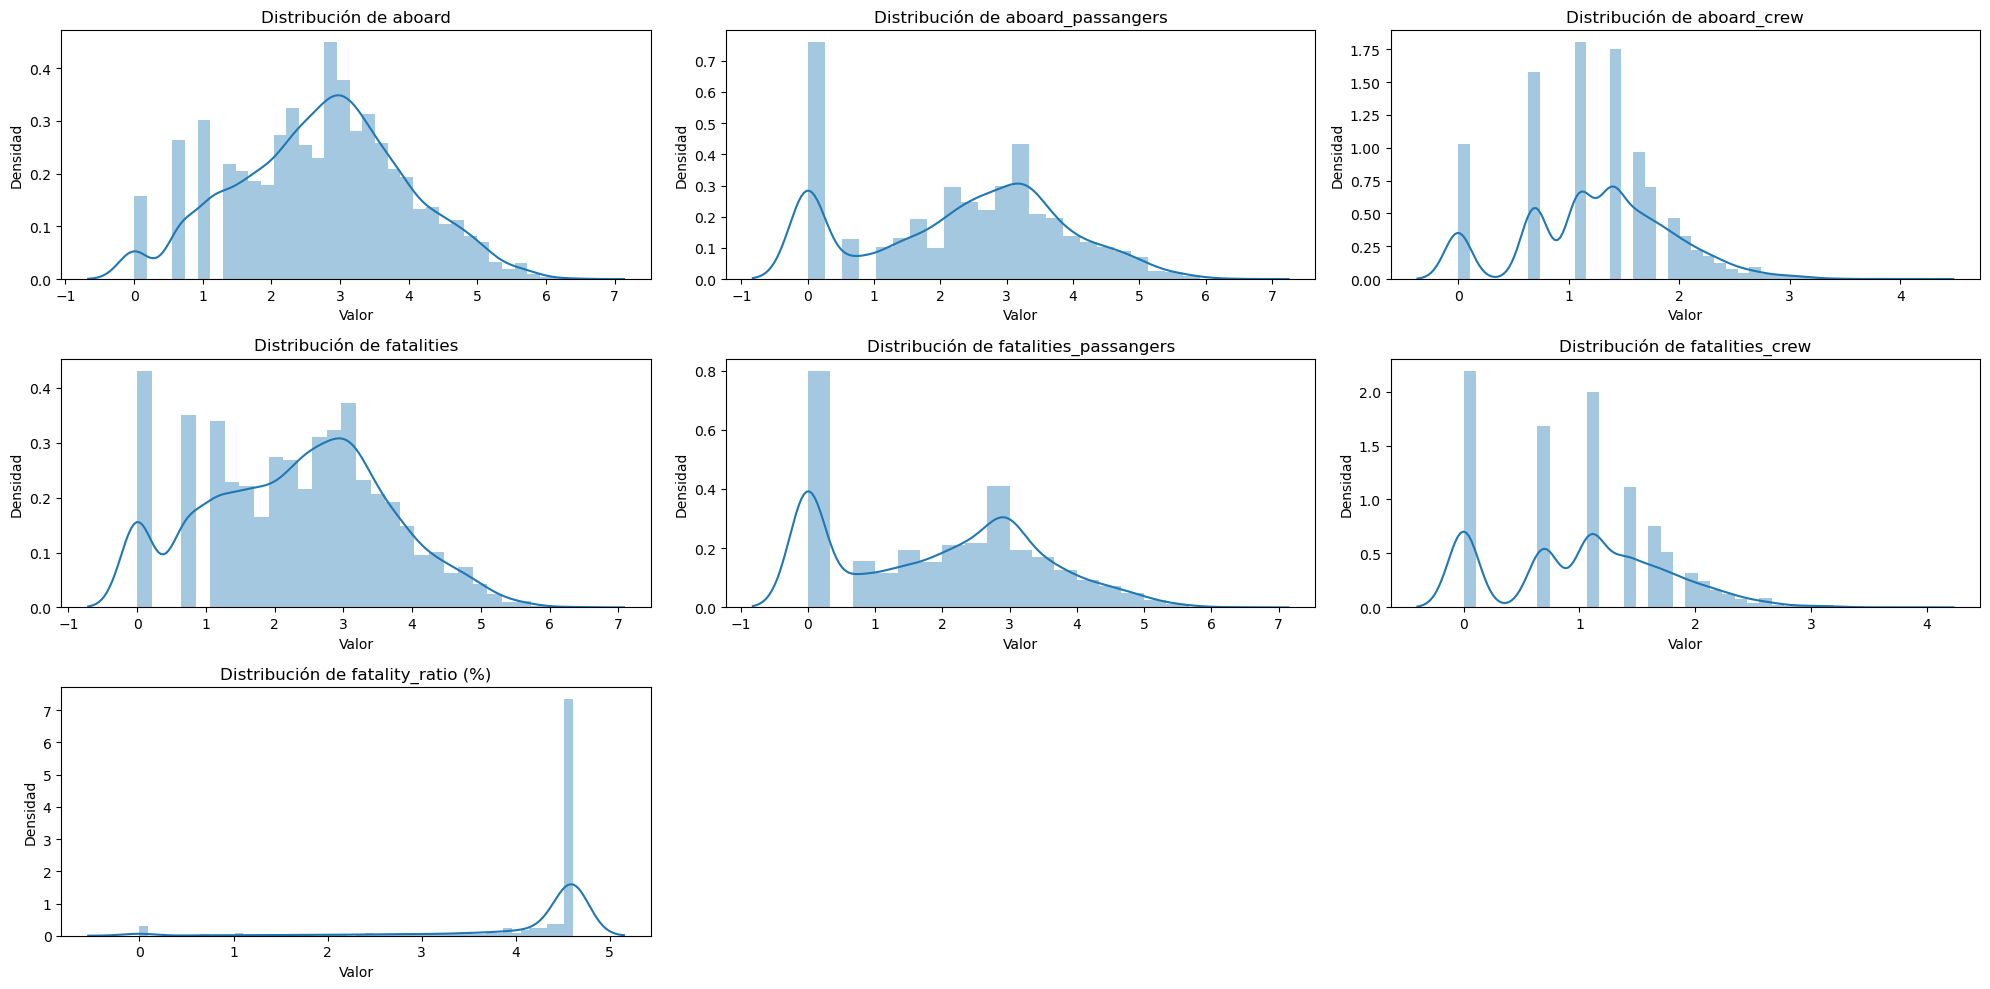

In [70]:
# En cuanto a los outliers vemos que representas el 10% de los casos totales de la muestra, aqui decidimos aplicarle un log.
# Definir la función de transformación
def log_transfom_clean1(x):
    x = np.log(x)
    if np.isfinite(x):
        return x
    else:
        return 0
# Aplicar la función a las columnas especificadas
columns_to_transform = ['aboard', 'aboard_passangers', 'aboard_crew', 
                        'fatalities', 'fatalities_passangers', 'fatalities_crew', 
                        'fatality_ratio (%)']
for column in columns_to_transform:
    datax[column] = datax[column].apply(log_transfom_clean1)
# Mostrar las distribuciones antes y después de la transformación
plt.figure(figsize=(20, 10))  # Ajusta el tamaño de la figura según sea necesario
num_columns = len(columns_to_transform)
num_rows = (num_columns // 3) + (num_columns % 3 > 0)  # Calcula el número de filas necesario

for i, column in enumerate(columns_to_transform, 1):
    plt.subplot(num_rows, 3, i)  # Ajusta el número de columnas según sea necesario
    sns.distplot(datax[column])
    plt.title(f'Distribución de {column}')
    plt.xlabel('Valor')
    plt.ylabel('Densidad')

plt.tight_layout()
plt.show()

In [71]:
datax.sample(10)

,date,year,month,day,city,country,operator,ac_type,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,fatality_ratio (%)
4079,1997-07-11,1997,7,11,Off Santiago de Cuba,Cuba,Cubana de Aviacion,Antonov AN-24,3.784190,3.663562,1.609438,3.784190,3.663562,1.609438,4.605170
4790,2011-07-11,2011,7,11,Near Strezhevoy,Russia,Angara Airlines,Antonov An-24RV,3.610918,3.496508,1.386294,1.945910,1.945910,0.000000,2.890372
1511,1955-04-18,1955,4,18,Kupe Mountains,Cameroons,Union des Transportes Aeriens,de Havilland DH-114 Heron 1B,2.639057,2.302585,1.386294,2.484907,2.197225,1.098612,4.442651
3437,1987-10-19,1987,10,19,Komsomolsk,Russia,MAP,Antonov An-12B,2.197225,0.693147,1.945910,2.197225,0.693147,1.945910,4.605170
1224,1951-01-20,1951,1,20,Huilyo,Peru,Military - TAM,Douglas DC-3,3.433987,3.295837,1.386294,2.772589,2.944439,1.098612,4.394449
4663,2008-06-26,2008,6,26,Near Salak Mountain,Indonesia,Military - Indonesian Air Force,CASA NC-212,2.890372,2.564949,1.609438,2.890372,2.564949,1.609438,4.605170
2440,1970-01-25,1970,1,25,Near Poza Rica,Mexico,Charter -Federal Electricity Commission,Convair CV-240-2,2.944439,2.708050,1.386294,2.890372,2.639057,1.386294,4.543295
4373,2002-05-21,2002,5,21,Near Calabar,Nigeria,Sky Executive Air Services,LET 410UVP,1.609438,0.000000,1.609438,1.609438,0.000000,1.609438,4.605170
3762,1992-08-21,1992,8,21,Colorado,Bolivia,Servicios Aereos Santa Ana,Convair CV-440-80,2.302585,1.945910,1.098612,2.302585,1.945910,1.098612,4.605170
1322,1952-05-09,1952,5,9,Ipoh,Malaysia,Garuda Indonesia Airlines,Douglas DC-3,2.833213,3.295837,1.386294,2.833213,2.944439,1.098612,4.605170


In [72]:
columns_to_drop = ['date', 'aboard_passangers', 'aboard_crew', 'fatalities_passangers', 'fatalities_crew']
datax.drop(columns=columns_to_drop, inplace=True)
datax

,year,month,day,city,country,operator,ac_type,aboard,fatalities,fatality_ratio (%)
0,1908,9,17,Fort Myer,EE. UU.,Military - U.S. Army,Wright Flyer III,0.693147,0.000000,3.912023
1,1909,9,7,Juvisy,France,Unknown,Wright Byplane,0.000000,0.000000,4.605170
2,1912,7,12,Atlantic City,EE. UU.,Military - U.S. Navy,Dirigible,1.609438,1.609438,4.605170
3,1913,8,6,Victoria,Canadá,Private,Curtiss seaplane,0.000000,0.000000,4.605170
4,1913,9,9,Over the North Sea,Over the North Sea,Military - German Navy,Zeppelin L-1 (airship),2.995732,2.639057,4.248495
...,...,...,...,...,...,...,...,...,...,...
4993,2022,11,21,Medellín,Colombia,AeroPaca SAS,Piper PA-31-350 Navajo Chieftain,2.079442,2.079442,4.605170
4994,2023,1,15,Pokhara,Nepal,Yeti Airlines,ATR 72-500-72-212-A,4.276666,4.276666,4.605170
4995,2023,9,16,Barcelos,Brazil,Manaus Aerotaxi,Embraer EMB-110P1 Bandeirante,2.639057,2.639057,4.605170
4996,2023,10,29,Rio Branco,Brazil,ART Taxi Aero,Cessna 208B Grand Caravan,2.484907,2.484907,4.605170


In [73]:
# Seguramente tenga que eliminar mis columnas categoricas para poder realizar el modelo ya que me falto tiempo para poder realizar un label encoder o dummies de forma correcta ya que tengo una locura de cantidad de variables distinas en mis columnas categoricas.

In [74]:
#Scaling and Normalizing
X_num=datax.select_dtypes(include=np.number)
X_num.head()

,year,month,day,aboard,fatalities,fatality_ratio (%)
0,1908,9,17,0.693147,0.000000,3.912023
1,1909,9,7,0.000000,0.000000,4.605170
2,1912,7,12,1.609438,1.609438,4.605170
3,1913,8,6,0.000000,0.000000,4.605170
4,1913,9,9,2.995732,2.639057,4.248495


In [75]:
#Scaling
transformer=MinMaxScaler().fit(X_num)
transformer
x_scaled=transformer.transform(X_num)
print(x_scaled.shape)
pd.DataFrame(x_scaled)

(4998, 6)


,0,1,2,3,4,5
0,0.000000,0.727273,0.533333,0.107171,0.000000,0.849485
1,0.008696,0.727273,0.200000,0.000000,0.000000,1.000000
2,0.034783,0.545455,0.366667,0.248842,0.252731,1.000000
3,0.043478,0.636364,0.166667,0.000000,0.000000,1.000000
4,0.043478,0.727273,0.266667,0.463184,0.414413,0.922549
...,...,...,...,...,...,...
4993,0.991304,0.909091,0.666667,0.321512,0.326536,1.000000
4994,1.000000,0.000000,0.466667,0.661235,0.671567,1.000000
4995,1.000000,0.727273,0.500000,0.408037,0.414413,1.000000
4996,1.000000,0.818182,0.933333,0.384203,0.390206,1.000000


In [76]:
pd.DataFrame(x_scaled).describe()

,0,1,2,3,4,5
count,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000
mean,0.547746,0.518262,0.493124,0.422592,0.363518,0.904522
std,0.215622,0.321014,0.293503,0.189305,0.205033,0.216531
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.373913,0.272727,0.233333,0.300866,0.217691,0.937531
50%,0.539130,0.545455,0.500000,0.428682,0.376543,1.000000
75%,0.730435,0.818182,0.733333,0.549708,0.505462,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [77]:
#Normalizando 
transformer=StandardScaler().fit(X_num)
x_normalized=transformer.transform(X_num)
print(x_normalized.shape)
pd.DataFrame(x_normalized)

(4998, 6)


,0,1,2,3,4,5
0,-2.540565,0.651161,0.137012,-1.666375,-1.773152,-0.254201
1,-2.500233,0.651161,-0.998807,-2.232559,-1.773152,0.440988
2,-2.379236,0.084717,-0.430898,-0.917920,-0.540393,0.440988
3,-2.338903,0.367939,-1.112389,-2.232559,-1.773152,0.440988
4,-2.338903,0.651161,-0.771643,0.214448,0.248251,0.083263
...,...,...,...,...,...,...
4993,2.057320,1.217605,0.591340,-0.534007,-0.180391,0.440988
4994,2.097652,-1.614614,-0.090152,1.260754,1.502587,0.440988
4995,2.097652,0.651161,0.023430,-0.076895,0.248251,0.440988
4996,2.097652,0.934383,1.499995,-0.202810,0.130178,0.440988


In [78]:
pd.DataFrame(x_normalized).describe()

,0,1,2,3,4,5
count,4.998000e+03,4.998000e+03,4.998000e+03,4.998000e+03,4.998000e+03,4.998000e+03
mean,1.546760e-15,-1.094674e-16,6.681774e-17,-3.411970e-17,3.582568e-16,-7.961263e-17
std,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00
min,-2.540565e+00,-1.614614e+00,-1.680299e+00,-2.232559e+00,-1.773152e+00,-4.177745e+00
25%,-8.062752e-01,-7.649485e-01,-8.852253e-01,-6.430795e-01,-7.113111e-01,1.524587e-01
50%,-3.996111e-02,8.471724e-02,2.342996e-02,3.217723e-02,6.353102e-02,4.409880e-01
75%,8.473499e-01,9.343830e-01,8.185033e-01,6.715593e-01,6.923663e-01,4.409880e-01
max,2.097652e+00,1.500827e+00,1.727159e+00,3.050458e+00,3.104601e+00,4.409880e-01


In [79]:
datax_copy = datax.copy()
datax_copy

,year,month,day,city,country,operator,ac_type,aboard,fatalities,fatality_ratio (%)
0,1908,9,17,Fort Myer,EE. UU.,Military - U.S. Army,Wright Flyer III,0.693147,0.000000,3.912023
1,1909,9,7,Juvisy,France,Unknown,Wright Byplane,0.000000,0.000000,4.605170
2,1912,7,12,Atlantic City,EE. UU.,Military - U.S. Navy,Dirigible,1.609438,1.609438,4.605170
3,1913,8,6,Victoria,Canadá,Private,Curtiss seaplane,0.000000,0.000000,4.605170
4,1913,9,9,Over the North Sea,Over the North Sea,Military - German Navy,Zeppelin L-1 (airship),2.995732,2.639057,4.248495
...,...,...,...,...,...,...,...,...,...,...
4993,2022,11,21,Medellín,Colombia,AeroPaca SAS,Piper PA-31-350 Navajo Chieftain,2.079442,2.079442,4.605170
4994,2023,1,15,Pokhara,Nepal,Yeti Airlines,ATR 72-500-72-212-A,4.276666,4.276666,4.605170
4995,2023,9,16,Barcelos,Brazil,Manaus Aerotaxi,Embraer EMB-110P1 Bandeirante,2.639057,2.639057,4.605170
4996,2023,10,29,Rio Branco,Brazil,ART Taxi Aero,Cessna 208B Grand Caravan,2.484907,2.484907,4.605170


In [80]:
columns_to_drop = ['city', 'country', 'operator', 'ac_type']
datax_copy.drop(columns=columns_to_drop, inplace=True)
datax_copy

,year,month,day,aboard,fatalities,fatality_ratio (%)
0,1908,9,17,0.693147,0.000000,3.912023
1,1909,9,7,0.000000,0.000000,4.605170
2,1912,7,12,1.609438,1.609438,4.605170
3,1913,8,6,0.000000,0.000000,4.605170
4,1913,9,9,2.995732,2.639057,4.248495
...,...,...,...,...,...,...
4993,2022,11,21,2.079442,2.079442,4.605170
4994,2023,1,15,4.276666,4.276666,4.605170
4995,2023,9,16,2.639057,2.639057,4.605170
4996,2023,10,29,2.484907,2.484907,4.605170


In [81]:
Y=datax_copy["fatalities"]
data2=datax_copy.drop(["fatalities"], axis=1)

In [82]:
x_num=data2.select_dtypes(include=np.number)

In [83]:
optimusprime=StandardScaler().fit(x_num)
x_standarized=optimusprime.transform(x_num)

In [84]:
Y

0       0.000000
1       0.000000
2       1.609438
3       0.000000
4       2.639057
          ...   
4993    2.079442
4994    4.276666
4995    2.639057
4996    2.484907
4997    1.386294
Name: fatalities, Length: 4998, dtype: float64

In [85]:
X=x_standarized
X

array([[-2.54056493,  0.65116108,  0.13701187, -1.66637515, -0.25420061],
       [-2.50023261,  0.65116108, -0.99880723, -2.23255928,  0.44098801],
       [-2.37923565,  0.08471724, -0.43089768, -0.91792045,  0.44098801],
       ...,
       [ 2.09765182,  0.65116108,  0.02342996, -0.07689535,  0.44098801],
       [ 2.09765182,  0.934383  ,  1.4999948 , -0.20281041,  0.44098801],
       [ 2.09765182,  1.21760492, -1.68029869, -1.10019102,  0.44098801]])

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state=42)

In [87]:
lm=linear_model.LinearRegression()
model=lm.fit(X_train, y_train)

In [88]:
predictions=lm.predict(X_test)

In [89]:
mse=mean_squared_error(y_test, predictions)
print(mse)
rmse=math.sqrt(mse)
print(rmse)

0.0731433576225956
0.2704502867859371


In [90]:
r2=r2_score(y_test, predictions)
print(r2)

0.956962578510965


In [91]:
Y = datax_copy["fatalities"] #variable dependiente
X = datax_copy.drop(["fatalities"], axis=1) # defino mi dataframe de variables independientes
# The linear model has the formula Y = a * X + b, with 'add_constant' we force the model
# to have an intercept because by default on statsmodel library the `linear models`
# doesn't have intercept!!!
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

print(model.summary()) #hacer siempre esto en supervisados
# en este modelo nos interesa ver siempre el r-squared que tiene que estar 0.5 para arriba (puede que sea mas bajo si las varibales y dependan de x)
# mirar siemore el coef y el P>/t/ si es mas de 0.1 es no significativa, menos es significativo

                            OLS Regression Results                            
Dep. Variable:             fatalities   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                 2.474e+04
Date:                Wed, 08 May 2024   Prob (F-statistic):               0.00
Time:                        16:40:10   Log-Likelihood:                -304.01
No. Observations:                4998   AIC:                             620.0
Df Residuals:                    4992   BIC:                             659.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.8876      0

In [92]:
datax_copy2 = datax.copy()
datax_copy2

,year,month,day,city,country,operator,ac_type,aboard,fatalities,fatality_ratio (%)
0,1908,9,17,Fort Myer,EE. UU.,Military - U.S. Army,Wright Flyer III,0.693147,0.000000,3.912023
1,1909,9,7,Juvisy,France,Unknown,Wright Byplane,0.000000,0.000000,4.605170
2,1912,7,12,Atlantic City,EE. UU.,Military - U.S. Navy,Dirigible,1.609438,1.609438,4.605170
3,1913,8,6,Victoria,Canadá,Private,Curtiss seaplane,0.000000,0.000000,4.605170
4,1913,9,9,Over the North Sea,Over the North Sea,Military - German Navy,Zeppelin L-1 (airship),2.995732,2.639057,4.248495
...,...,...,...,...,...,...,...,...,...,...
4993,2022,11,21,Medellín,Colombia,AeroPaca SAS,Piper PA-31-350 Navajo Chieftain,2.079442,2.079442,4.605170
4994,2023,1,15,Pokhara,Nepal,Yeti Airlines,ATR 72-500-72-212-A,4.276666,4.276666,4.605170
4995,2023,9,16,Barcelos,Brazil,Manaus Aerotaxi,Embraer EMB-110P1 Bandeirante,2.639057,2.639057,4.605170
4996,2023,10,29,Rio Branco,Brazil,ART Taxi Aero,Cessna 208B Grand Caravan,2.484907,2.484907,4.605170


In [93]:
columns_to_drop = ['city', 'country', 'operator', 'ac_type']
datax_copy2.drop(columns=columns_to_drop, inplace=True)
datax_copy2

,year,month,day,aboard,fatalities,fatality_ratio (%)
0,1908,9,17,0.693147,0.000000,3.912023
1,1909,9,7,0.000000,0.000000,4.605170
2,1912,7,12,1.609438,1.609438,4.605170
3,1913,8,6,0.000000,0.000000,4.605170
4,1913,9,9,2.995732,2.639057,4.248495
...,...,...,...,...,...,...
4993,2022,11,21,2.079442,2.079442,4.605170
4994,2023,1,15,4.276666,4.276666,4.605170
4995,2023,9,16,2.639057,2.639057,4.605170
4996,2023,10,29,2.484907,2.484907,4.605170


In [94]:
Y=datax_copy["fatalities"]
data3=datax_copy2.drop(["fatalities"], axis=1)

In [95]:
x_num=data3.select_dtypes(include=np.number)

In [96]:
#Normalizar datos
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(x_num)
x_normalized=transformer.transform(x_num)
print(x_normalized)

[[9.99947019e-01 4.71673122e-03 8.90938119e-03 3.63265438e-04
  2.05021789e-03]
 [9.99979255e-01 4.71441241e-03 3.66676521e-03 0.00000000e+00
  2.41229683e-03]
 [9.99970350e-01 3.66097931e-03 6.27596454e-03 8.41731272e-04
  2.40849040e-03]
 ...
 [9.99955388e-01 4.44863989e-03 7.90869314e-03 1.30446841e-03
  2.27630487e-03]
 [9.99881710e-01 4.94256901e-03 1.43334501e-02 1.22818226e-03
  2.27613714e-03]
 [9.99982269e-01 5.43737270e-03 4.94306609e-04 6.85254464e-04
  2.27636606e-03]]


In [97]:
Y

0       0.000000
1       0.000000
2       1.609438
3       0.000000
4       2.639057
          ...   
4993    2.079442
4994    4.276666
4995    2.639057
4996    2.484907
4997    1.386294
Name: fatalities, Length: 4998, dtype: float64

In [98]:
X=x_normalized
X

array([[9.99947019e-01, 4.71673122e-03, 8.90938119e-03, 3.63265438e-04,
        2.05021789e-03],
       [9.99979255e-01, 4.71441241e-03, 3.66676521e-03, 0.00000000e+00,
        2.41229683e-03],
       [9.99970350e-01, 3.66097931e-03, 6.27596454e-03, 8.41731272e-04,
        2.40849040e-03],
       ...,
       [9.99955388e-01, 4.44863989e-03, 7.90869314e-03, 1.30446841e-03,
        2.27630487e-03],
       [9.99881710e-01, 4.94256901e-03, 1.43334501e-02, 1.22818226e-03,
        2.27613714e-03],
       [9.99982269e-01, 5.43737270e-03, 4.94306609e-04, 6.85254464e-04,
        2.27636606e-03]])

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state=42)

In [100]:
lm=linear_model.LinearRegression()
model=lm.fit(X_train, y_train)

In [201]:
predictions=lm.predict(X_test)

In [203]:
mse=mean_squared_error(y_test, predictions)
print(mse)
rmse=math.sqrt(mse)
print(rmse)

0.0795703760650681
0.2820822150811144


In [205]:
r2=r2_score(y_test, predictions)
print(r2)

0.9531809322943161


In [207]:
Y = datax_copy2["fatalities"] #variable dependiente
X = datax_copy2.drop(["fatalities"], axis=1) # defino mi dataframe de variables independientes
# The linear model has the formula Y = a * X + b, with 'add_constant' we force the model
# to have an intercept because by default on statsmodel library the `linear models`
# doesn't have intercept!!!
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

print(model.summary()) #hacer siempre esto en supervisados
# en este modelo nos interesa ver siempre el r-squared que tiene que estar 0.5 para arriba (puede que sea mas bajo si las varibales y dependan de x)
# mirar siemore el coef y el P>/t/ si es mas de 0.1 es no significativa, menos es significativo

                            OLS Regression Results                            
Dep. Variable:             fatalities   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                 2.474e+04
Date:                Wed, 08 May 2024   Prob (F-statistic):               0.00
Time:                        16:41:22   Log-Likelihood:                -304.01
No. Observations:                4998   AIC:                             620.0
Df Residuals:                    4992   BIC:                             659.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.8876      0